# **Using a single model structure to predict the data**

With this model, we try to have the more robust possible architecture, capable of predicting new agents or stations, without extensive retraining.

In particular, the strategy used is named Multi Task Learning and will employ one embedder model with per-agent regression heads attached.

## **Data Import**

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
import keras

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

c:\Users\Davide\Documents\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = sorted(pollution_data.keys())
agents = sorted(set(agent for station in stations for agent in pollution_data[station].keys()))

## **Data Merging**

- Traffic data is per-station, but it should be normalized globally. To do so we first merge the data, we apply normalization, and later use the date and the stations to merge the data with the pollutants.

In [3]:
merged_traffic_data = pd.concat(
    [df.assign(Station=key) for key, df in traffic_data.items()]
)
print(merged_traffic_data.resample('1h').max().isna().sum())
merged_traffic_data

Traffic_value    0
Station          0
dtype: int64


Traffic_value              Station
Date                                                   
2019-01-01 00:00:00        27629.0  GIARDINI MARGHERITA
2019-01-01 01:00:00        44430.0  GIARDINI MARGHERITA
2019-01-01 02:00:00        40318.0  GIARDINI MARGHERITA
2019-01-01 03:00:00        25661.0  GIARDINI MARGHERITA
2019-01-01 04:00:00        15906.0  GIARDINI MARGHERITA
...                            ...                  ...
2024-12-31 19:00:00        19786.0         VIA CHIARINI
2024-12-31 20:00:00        16239.0         VIA CHIARINI
2024-12-31 21:00:00         7226.0         VIA CHIARINI
2024-12-31 22:00:00         5568.0         VIA CHIARINI
2024-12-31 23:00:00         4587.0         VIA CHIARINI

[157824 rows x 2 columns]

In [4]:
scaler = StandardScaler()
scaled_traffic_data = merged_traffic_data.copy()
scaled_traffic_data['Traffic_value'] = scaler.fit_transform(merged_traffic_data[['Traffic_value']])
scaled_traffic_data

Traffic_value              Station
Date                                                   
2019-01-01 00:00:00      -0.365193  GIARDINI MARGHERITA
2019-01-01 01:00:00       0.115231  GIARDINI MARGHERITA
2019-01-01 02:00:00      -0.002351  GIARDINI MARGHERITA
2019-01-01 03:00:00      -0.421468  GIARDINI MARGHERITA
2019-01-01 04:00:00      -0.700413  GIARDINI MARGHERITA
...                            ...                  ...
2024-12-31 19:00:00      -0.589464         VIA CHIARINI
2024-12-31 20:00:00      -0.690890         VIA CHIARINI
2024-12-31 21:00:00      -0.948617         VIA CHIARINI
2024-12-31 22:00:00      -0.996028         VIA CHIARINI
2024-12-31 23:00:00      -1.024079         VIA CHIARINI

[157824 rows x 2 columns]

- weather data is global, we only have to normalize it. Since that it is a single df, we add the date encodings to this dataframe for semplicity. Encodings seemed to be very helpful with single models.

In [5]:
scaler = StandardScaler()
encoded_weather_data = encode_date_index(weather_data.copy(), method='radial_months-sin-cos_days_hours')
scaled_weather_data = encoded_weather_data.copy()
scaled_weather_data[:] = scaler.fit_transform(scaled_weather_data)
print(scaled_weather_data.resample('1h').max().isna().sum())
scaled_weather_data

TAVG            0
PREC            0
RHAVG           0
RAD             0
W_SCAL_INT      0
W_VEC_DIR       0
LEAFW           0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_rbf_1     0
month_rbf_2     0
month_rbf_3     0
month_rbf_4     0
month_rbf_5     0
month_rbf_6     0
month_rbf_7     0
month_rbf_8     0
month_rbf_9     0
month_rbf_10    0
month_rbf_11    0
month_rbf_12    0
dtype: int64


TAVG      PREC     RHAVG       RAD  W_SCAL_INT  \
Date                                                                      
2019-01-01 00:00:00 -1.746273 -0.136857  1.317050 -0.661661   -1.419546   
2019-01-01 01:00:00 -1.828240 -0.136857  1.381442 -0.661661   -1.419546   
2019-01-01 02:00:00 -1.781402 -0.136857  1.287330 -0.661661   -1.088536   
2019-01-01 03:00:00 -1.816531 -0.136857  1.277424 -0.661661   -1.309209   
2019-01-01 04:00:00 -1.746273 -0.136857  1.019854 -0.661661   -1.309209   
...                       ...       ...       ...       ...         ...   
2024-12-30 20:00:00 -1.137371 -0.136857  0.316492 -0.661661   -0.592021   
2024-12-30 21:00:00 -1.207629 -0.136857  0.514622 -0.661661   -0.316180   
2024-12-30 22:00:00 -1.195919 -0.136857  0.474996 -0.661661   -0.150675   
2024-12-30 23:00:00 -1.266177 -0.136857  0.514622 -0.661661   -0.150675   
2024-12-31 00:00:00 -1.266177 -0.136857  0.460137 -0.661661   -0.150675   

                     W_VEC_DIR    LEAFW      hour_sin  hour_cos       day_sin  \
Date                                                                            
2019-01-01 00:00:00   0.045086 -0.46528  2.613213e-17  1.414173  2.846169e-01   
2019-01-01 01:00:00   0.846485 -0.46528  3.660289e-01  1.365986  2.846169e-01   
2019-01-01 02:00:00  -0.523648 -0.46528  7.071135e-01  1.224706  2.846169e-01   
2019-01-01 03:00:00  -0.171842 -0.46528  1.000010e+00  0.999964  2.846169e-01   
2019-01-01 04:00:00  -0.357299 -0.46528  1.224757e+00  0.707073  2.846169e-01   
...                        ...      ...           ...       ...           ...   
2024-12-30 20:00:00   0.721724 -0.46528 -1.224757e+00  0.707073 -2.846169e-01   
2024-12-30 21:00:00   0.599209 -0.46528 -1.000010e+00  0.999964 -2.846169e-01   
2024-12-30 22:00:00   0.555374 -0.46528 -7.071135e-01  1.224706 -2.846169e-01   
2024-12-30 23:00:00   0.584598 -0.46528 -3.660289e-01  1.365986 -2.846169e-01   
2024-12-31 00:00:00   0.602581 -0.46528  2.613213e-17  1.414173 -3.417215e-16   

                     ...  month_rbf_3  month_rbf_4  month_rbf_5  month_rbf_6  \
Date                 ...                                                       
2019-01-01 00:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 01:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 02:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 03:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 04:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
...                  ...          ...          ...          ...          ...   
2024-12-30 20:00:00  ...    -0.385392    -0.386145    -0.387749    -0.386156   
2024-12-30 21:00:00  ...    -0.385392    -0.386145    -0.387749    -0.386156   
2024-12-30 22:00:00  ...    -0.385392    -0.386145    -0.387749    -0.386156   
2024-12-30 23:00:00  ...    -0.385392    -0.386145    -0.387749    -0.386156   
2024-12-31 00:00:00  ...    -0.385392    -0.386145    -0.387749    -0.386156   

                     month_rbf_7  month_rbf_8  month_rbf_9  month_rbf_10  \
Date                                                                       
2019-01-01 00:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 01:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 02:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 03:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 04:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
...                          ...          ...          ...           ...   
2024-12-30 20:00:00    -0.389161    -0.389161    -0.386155     -0.386535   
2024-12-30 21:00:00    -0.389161    -0.389161    -0.386155     -0.386535   
2024-12-30 22:00:00    -0.389161    -0.389161    -0.386155     -0.386535   
2024-12-30 23:00:00    -0.389161    -0.389161    -0.386155     -0.386535   
2024-12-31 00:00:00    -0.389161    -0.389

- The agent values should be standardized to avoid exploding losses.

In [6]:
for station in stations:
    for agent, d_agent_values in pollution_data[station].items():
        num = d_agent_values.isna().sum()['Agent_value']
        if num > 0:
            print(f'Found {num} nan values in {agent}-{station}')
        pollution_data[station][agent] = d_agent_values.dropna()


Found 12 nan values in PM2.5-GIARDINI MARGHERITA


In [7]:
for station in stations:
    print(station)
    for agent, d_agent_values in pollution_data[station].items():
        print(f'{agent}, mean:{d_agent_values.mean().values}, std:{d_agent_values.std().values}')

GIARDINI MARGHERITA
NO2, mean:[17.1419415], std:[12.5876588]
O3, mean:[48.97226624], std:[37.84988982]
PM10, mean:[22.27748691], std:[14.5251379]
PM2.5, mean:[14.08041627], std:[11.65675545]
PORTA SAN FELICE
C6H6, mean:[0.9689665], std:[0.73308301]
CO, mean:[0.5785757], std:[0.31027225]
NO2, mean:[39.71157278], std:[19.29114331]
PM10, mean:[25.36431574], std:[15.49784178]
PM2.5, mean:[15.63339552], std:[11.86983867]
VIA CHIARINI
NO2, mean:[17.89649031], std:[13.34140254]
O3, mean:[44.28980391], std:[38.50620415]
PM10, mean:[22.30033003], std:[13.79587869]


Each agent should be standardized across all the stations, since that the model heads will be per agent and not per station-agent.

In [8]:
agent_distributions = {} # dict agent:tuple[mean, std]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    agent_distributions[agent] = (aux.mean().values[0], aux.std().values[0])

agent_distributions

{'C6H6': (0.9689665038523635, 0.7330830114927064),
 'CO': (0.5785757043273408, 0.310272252729056),
 'NO2': (24.91522027214842, 18.593215143820412),
 'O3': (46.635182621659034, 38.250409901350025),
 'PM10': (23.323746660380323, 14.695789140629058),
 'PM2.5': (14.862376702677313, 11.78875366118643)}

*Verify the transformation:*

In [9]:
pollution_data['GIARDINI MARGHERITA']['NO2']

Agent_value
Date                            
2019-01-01 00:00:00         29.0
2019-01-01 02:00:00         23.0
2019-01-01 03:00:00         29.0
2019-01-01 04:00:00         26.0
2019-01-01 05:00:00         24.0
...                          ...
2024-12-31 19:00:00         23.0
2024-12-31 20:00:00         22.0
2024-12-31 21:00:00         18.0
2024-12-31 22:00:00         22.0
2024-12-31 23:00:00         21.0

[51486 rows x 1 columns]

In [10]:
for station in stations:
    for agent in pollution_data[station]:
        pollution_data[station][agent] = (pollution_data[station][agent] - agent_distributions[agent][0]) / agent_distributions[agent][1]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    print(agent, round(aux.mean().values[0], 2), round(aux.std().values[0], 2))

C6H6 0.0 1.0
CO -0.0 1.0
NO2 0.0 1.0
O3 0.0 1.0
PM10 0.0 1.0
PM2.5 0.0 1.0


In [11]:
pollution_data['GIARDINI MARGHERITA']['NO2']

Agent_value
Date                            
2019-01-01 00:00:00     0.219692
2019-01-01 02:00:00    -0.103006
2019-01-01 03:00:00     0.219692
2019-01-01 04:00:00     0.058343
2019-01-01 05:00:00    -0.049223
...                          ...
2024-12-31 19:00:00    -0.103006
2024-12-31 20:00:00    -0.156789
2024-12-31 21:00:00    -0.371922
2024-12-31 22:00:00    -0.156789
2024-12-31 23:00:00    -0.210573

[51486 rows x 1 columns]

- We can now divide the traffic per station, merge them with the weather and create the input sequences. For every agent of the same station, the input data is the same.
    

In [12]:
station_data = {
    station: pd.merge(
        scaled_traffic_data[scaled_traffic_data['Station'] == station].drop(columns=['Station']),
        scaled_weather_data,
        left_index=True,
        right_index=True
    )
    for station in stations
}
for station in station_data:
    display(station, f'Number of nans: {np.sum(station_data[station].resample("1h").max().isna().sum().values)}', station_data[station].head(3))

'GIARDINI MARGHERITA'

'Number of nans: 0'

Traffic_value      TAVG      PREC     RHAVG       RAD  \
Date                                                                         
2019-01-01 00:00:00      -0.365193 -1.746273 -0.136857  1.317050 -0.661661   
2019-01-01 01:00:00       0.115231 -1.828240 -0.136857  1.381442 -0.661661   
2019-01-01 02:00:00      -0.002351 -1.781402 -0.136857  1.287330 -0.661661   

                     W_SCAL_INT  W_VEC_DIR    LEAFW      hour_sin  hour_cos  \
Date                                                                          
2019-01-01 00:00:00   -1.419546   0.045086 -0.46528  2.613213e-17  1.414173   
2019-01-01 01:00:00   -1.419546   0.846485 -0.46528  3.660289e-01  1.365986   
2019-01-01 02:00:00   -1.088536  -0.523648 -0.46528  7.071135e-01  1.224706   

                     ...  month_rbf_3  month_rbf_4  month_rbf_5  month_rbf_6  \
Date                 ...                                                       
2019-01-01 00:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 01:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 02:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   

                     month_rbf_7  month_rbf_8  month_rbf_9  month_rbf_10  \
Date                                                                       
2019-01-01 00:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 01:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 02:00:00    -0.389161    -0.389161    -0.386156     -0.387748   

                     month_rbf_11  month_rbf_12  
Date                                             
2019-01-01 00:00:00     -0.384695      0.102338  
2019-01-01 01:00:00     -0.384695      0.102338  
2019-01-01 02:00:00     -0.384695      0.102338  

[3 rows x 24 columns]

'PORTA SAN FELICE'

'Number of nans: 0'

Traffic_value      TAVG      PREC     RHAVG       RAD  \
Date                                                                         
2019-01-01 00:00:00       0.010659 -1.746273 -0.136857  1.317050 -0.661661   
2019-01-01 01:00:00       0.600117 -1.828240 -0.136857  1.381442 -0.661661   
2019-01-01 02:00:00       0.315997 -1.781402 -0.136857  1.287330 -0.661661   

                     W_SCAL_INT  W_VEC_DIR    LEAFW      hour_sin  hour_cos  \
Date                                                                          
2019-01-01 00:00:00   -1.419546   0.045086 -0.46528  2.613213e-17  1.414173   
2019-01-01 01:00:00   -1.419546   0.846485 -0.46528  3.660289e-01  1.365986   
2019-01-01 02:00:00   -1.088536  -0.523648 -0.46528  7.071135e-01  1.224706   

                     ...  month_rbf_3  month_rbf_4  month_rbf_5  month_rbf_6  \
Date                 ...                                                       
2019-01-01 00:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 01:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 02:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   

                     month_rbf_7  month_rbf_8  month_rbf_9  month_rbf_10  \
Date                                                                       
2019-01-01 00:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 01:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 02:00:00    -0.389161    -0.389161    -0.386156     -0.387748   

                     month_rbf_11  month_rbf_12  
Date                                             
2019-01-01 00:00:00     -0.384695      0.102338  
2019-01-01 01:00:00     -0.384695      0.102338  
2019-01-01 02:00:00     -0.384695      0.102338  

[3 rows x 24 columns]

'VIA CHIARINI'

'Number of nans: 0'

Traffic_value      TAVG      PREC     RHAVG       RAD  \
Date                                                                         
2019-01-01 00:00:00      -0.914904 -1.746273 -0.136857  1.317050 -0.661661   
2019-01-01 01:00:00      -0.724690 -1.828240 -0.136857  1.381442 -0.661661   
2019-01-01 02:00:00      -0.787827 -1.781402 -0.136857  1.287330 -0.661661   

                     W_SCAL_INT  W_VEC_DIR    LEAFW      hour_sin  hour_cos  \
Date                                                                          
2019-01-01 00:00:00   -1.419546   0.045086 -0.46528  2.613213e-17  1.414173   
2019-01-01 01:00:00   -1.419546   0.846485 -0.46528  3.660289e-01  1.365986   
2019-01-01 02:00:00   -1.088536  -0.523648 -0.46528  7.071135e-01  1.224706   

                     ...  month_rbf_3  month_rbf_4  month_rbf_5  month_rbf_6  \
Date                 ...                                                       
2019-01-01 00:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 01:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   
2019-01-01 02:00:00  ...    -0.384179    -0.386145    -0.387749    -0.386156   

                     month_rbf_7  month_rbf_8  month_rbf_9  month_rbf_10  \
Date                                                                       
2019-01-01 00:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 01:00:00    -0.389161    -0.389161    -0.386156     -0.387748   
2019-01-01 02:00:00    -0.389161    -0.389161    -0.386156     -0.387748   

                     month_rbf_11  month_rbf_12  
Date                                             
2019-01-01 00:00:00     -0.384695      0.102338  
2019-01-01 01:00:00     -0.384695      0.102338  
2019-01-01 02:00:00     -0.384695      0.102338  

[3 rows x 24 columns]

## **Sequences**

Sequences should also be indexed with the date of the last element, so that merging with the agent will be easier. To do so, we simply use one variable for the sequences and one for the dates.

In [13]:
hourly_time_steps = 3
daily_time_steps = 24

In [14]:
station_sliding_windows = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station],
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=hourly_time_steps
    )
    dates = dates.index.tolist()
    station_sliding_windows[station] = sequences, dates

In [15]:
station_sequences = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station].drop(columns=['hour_sin', 'hour_cos']),
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=daily_time_steps,
        sliding_window=False
    ) 
    station_sequences[station] = sequences, dates

- At this point we should create the actual train data composed of sequence + agentID and the target values. We could create a single dataset and directly use it, but it will be too big and with too many repeated values (sequences are repeated for each agent and each sequence shares some rows).

    <!-- For now, I simply try to make a dataset made of `in=(station_date, sequence)`, `x=(station_date, agent)` and `y=(target)`. I don't want the model to learn station and agent.  -->
    The model should be able to take a batch and use the dates to access the sequences, create the embeddings, and use the agent to predict the concentration using the correct classification head. Since that we have to map a dict would be suitable for fast data access.

- Also, at this point we have to divide hourly and daily agents because the embedding we are trying to create for the stations can be quite different. For example if we have to predict an hourly pollutant, we might want to use 3/5 previous hours. For daily agents instead, the whole 24 hours might be helpful.

In [16]:
def create_key(station, date):
    return (station+' '+date).replace(' ','_')


def sort_lists(timestamps, *iterables):
    combined = zip(timestamps, *iterables)
    combined_sorted = sorted(combined, key=lambda x: x[0])
    unpacked = zip(*combined_sorted)
    # next(unpacked)  # skip timestamps
    return tuple(map(list, unpacked))


hourly_input_data = {}
daily_input_data = {}
for station in station_sequences:
    for seq, date in zip(station_sliding_windows[station][0], station_sliding_windows[station][1]):
        hourly_input_data[create_key(station, str(date))] = seq
    for seq, date in zip(station_sequences[station][0], station_sequences[station][1]):
        daily_input_data[create_key(station, str(date))] = seq

h_dates = []
h_keys = []
h_agents = []
h_values = []
h_stationsIDs = []

d_dates = []
d_keys = []
d_agents = []
d_values = []
d_stationsIDs = []

for station in pollution_data:
    for agent in pollution_data[station]:
        for target, date in zip(pollution_data[station][agent]['Agent_value'], pollution_data[station][agent].index):
            date = str(date)
            if agent in ('PM10', 'PM2.5'):
                d_dates.append(date)
                d_keys.append(create_key(station, date))
                d_agents.append(agent)
                d_values.append(target)
                d_stationsIDs.append(stations.index(station))
            else: 
                h_dates.append(date)
                h_keys.append(create_key(station, date))
                h_agents.append(agent)
                h_values.append(target)
                h_stationsIDs.append(stations.index(station))

# sort the arrays using the dates
h_dates, h_keys, h_agents, h_values, h_stationsIDs = sort_lists(h_dates, h_keys, h_agents, h_values, h_stationsIDs)
d_dates, d_keys, d_agents, d_values, d_stationsIDs = sort_lists(d_dates, d_keys, d_agents, d_values, d_stationsIDs)

In [17]:
print("NaN in h_values:", np.isnan(h_values).any())
print("NaN in d_values:", np.isnan(d_values).any())

NaN in h_values: False
NaN in d_values: False


## **Dataset**

The model will use a TensorFlow DataSet. The dataset is structured such that we only store the station and the timestamp of the input data that corresponds to the target values. Then, we use that key to access a dictionary containing the input sequences.

- Remove the rows where there is no input data

In [18]:
valid_h_indices = [i for i, k in enumerate(h_keys) if k in hourly_input_data]
h_keys          = [h_keys[i]        for i in valid_h_indices]
h_agents        = [h_agents[i]      for i in valid_h_indices]
h_values        = [h_values[i]      for i in valid_h_indices]
h_dates         = [h_dates[i]       for i in valid_h_indices]
h_stationsIDs   = [h_stationsIDs[i] for i in valid_h_indices]

valid_d_indices = [i for i, k in enumerate(d_keys) if k in daily_input_data]
d_keys          = [d_keys[i]        for i in valid_d_indices]
d_agents        = [d_agents[i]      for i in valid_d_indices]
d_values        = [d_values[i]      for i in valid_d_indices]
d_dates         = [d_dates[i]       for i in valid_d_indices]
d_stationsIDs   = [d_stationsIDs[i] for i in valid_d_indices]

- We keep the 2024 as test set

In [19]:
TRAIN_SPLIT = 1/6

unique_d_dates = np.unique(d_dates)
d_trainval_dates = unique_d_dates[:int(len(unique_d_dates)*(1 - TRAIN_SPLIT)) - 1]
d_test_dates = unique_d_dates[int(len(unique_d_dates)*(1 - TRAIN_SPLIT)) - 1:]
print('daily dates lenghts: ',len(d_trainval_dates), len(d_test_dates))

unique_h_dates = np.unique(h_dates)
h_trainval_dates = unique_h_dates[:int(len(unique_h_dates)*(1 - TRAIN_SPLIT)) - 1]
h_test_dates = unique_h_dates[int(len(unique_h_dates)*(1 - TRAIN_SPLIT)) - 1:]
print('hourly dates lenghts: ',len(h_trainval_dates), len(h_test_dates))

daily dates lenghts:  1815 365
hourly dates lenghts:  43812 8764


- and we use 10% of the remaining data for the validation sets. Before splitting, we shuffle the dates.\
Its important to note that we have multiple output values for each input key: when splitting into training and validation, we have to be sure that the same keys are in the same dataset.

In [20]:
VAL_SPLIT = 0.1

np.random.seed(42)
np.random.shuffle(d_trainval_dates)
np.random.shuffle(h_trainval_dates)

d_train_list, d_val_list, d_test_list = [], [], []
h_train_list, h_val_list, h_test_list = [], [], []

for d_key, d_agent, d_value, d_stationsID, d_date in zip(d_keys, d_agents, d_values, d_stationsIDs, d_dates):
    if d_date in d_trainval_dates:
        if d_date in d_trainval_dates[: int(len(d_trainval_dates)*VAL_SPLIT)]:
            d_val_list.append((d_key, d_agent, d_value, d_stationsID, d_date))
        else:
            d_train_list.append((d_key, d_agent, d_value, d_stationsID, d_date))
    else:
        d_test_list.append((d_key, d_agent, d_value, d_stationsID, d_date))

for h_key, h_agent, h_value, h_stationsID, h_date in zip(h_keys, h_agents, h_values, h_stationsIDs, h_dates):
    if h_date in h_trainval_dates:
        if h_date in h_trainval_dates[: int(len(h_trainval_dates)*VAL_SPLIT)]:
            h_val_list.append((h_key, h_agent, h_value, h_stationsID, h_date))
        else:
            h_train_list.append((h_key, h_agent, h_value, h_stationsID, h_date))
    else:
        h_test_list.append((h_key, h_agent, h_value, h_stationsID, h_date))

- We create the datasets

In [21]:
d_train = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_train_list  )))) # from list of tuples to tuple of lists
d_val   = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_val_list    ))))
d_test  = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *d_test_list   ))))

h_train = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_train_list  ))))
h_val   = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_val_list    ))))
h_test  = tf.data.Dataset.from_tensor_slices(tuple(list(z) for z in (zip( *h_test_list   ))))

- dataset mapping to use the keys to access the input sequences

In [22]:
def make_tf_loader(data_dict, time_steps, features):
    def _load_sample(key, _agent_id, val, _station_id, _date):
        k = key.numpy().decode("utf-8")
        date = _date.numpy().decode("utf-8")
        seq = data_dict[k].astype("float32")
        return seq, _agent_id, val, _station_id, date

    def _tf_load(key, _agent_id, val, _station_id, _date):
        seq, agent_id, value, station_id, date = tf.py_function(
            func=_load_sample,
            inp=[key, _agent_id, val, _station_id, _date],
            Tout=[tf.float32, tf.string, tf.float32, tf.int32, tf.string]
        )
        seq.set_shape([time_steps, features])
        agent_id.set_shape([])
        value.set_shape([])
        station_id.set_shape([])
        date.set_shape([])
        return seq, agent_id, value, station_id, date

    return _tf_load

In [23]:
hourly_input_shape = (list(hourly_input_data.values())[0]).shape
daily_input_shape =  (list(daily_input_data.values())[0]).shape
print(hourly_input_shape, daily_input_shape)

h_loader = make_tf_loader(hourly_input_data, *hourly_input_shape)
d_loader = make_tf_loader(daily_input_data, *daily_input_shape)

(3, 24) (24, 22)


In [ ]:
d_train = d_train.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000, seed=42)
d_val = d_val.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)
d_test = d_test.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)

h_train = h_train.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000, seed=42)
h_val = h_val.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)
h_test = h_test.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)

Final DataSets sizes:

In [25]:
print(len(d_train))
print(len(d_val))
print(len(d_test))
print(len(h_train))
print(len(h_val))
print(len(h_test))

7927
870
1764
268412
29803
60342


## **Model**

- As we said earlier, the model should be able to use the station and date to access the actual training sequences.

In [26]:
class MultiAgentModel(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        task_ids,
        lstm_units=(128, 64),
        head_hidden_units=(32,),
        head_dropout=0.2,
        mask_value=-999.0,
        seed=42
    ):
        super().__init__()

        self.in_shape = input_shape
        self.lstm_units = lstm_units
        self.head_hidden_units = head_hidden_units

        self.task_ids = tf.constant(task_ids, dtype=tf.string)
        self.task_id_to_index = {tid: i for i, tid in enumerate(task_ids)}

        self.encoder = tf.keras.Sequential(name="encoder")
        self.encoder.add(tf.keras.layers.Masking(mask_value=mask_value, input_shape=input_shape))
        for i, units in enumerate(lstm_units):
            self.encoder.add(tf.keras.layers.LSTM(
                units, return_sequences=(i < len(lstm_units) - 1), name=f"lstm_{i}"
            ))

        self.heads = []
        for tid in task_ids:
            head = tf.keras.Sequential(name=f"{tid}_head")
            head.add(tf.keras.layers.InputLayer(input_shape=(lstm_units[-1],)))
            for head_hidden_unit in head_hidden_units:
                head.add(tf.keras.layers.Dense(head_hidden_unit, activation="tanh"))
                head.add(tf.keras.layers.Dropout(head_dropout, seed=seed))
            head.add(tf.keras.layers.Dense(1))
            self.heads.append(head)

    def call(self, inputs, training=False):
        x, task_ids = inputs
        embs = self.encoder(x, training=training)

        lookup_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(list(self.task_id_to_index.keys()), dtype=tf.string),
                values=tf.constant(list(self.task_id_to_index.values()), dtype=tf.int32),
            ),
            default_value=-1
        )
        head_indices = lookup_table.lookup(task_ids)

        def apply_head(i):
            emb_i, head_idx = i

            def case_fn(j):
                return lambda: self.heads[j](tf.expand_dims(emb_i, axis=0), training=training)

            branches = [case_fn(j) for j in range(len(self.heads))]
            out = tf.switch_case(head_idx, branch_fns=branches)
            return out[0]

        preds = tf.map_fn(
            apply_head,
            (embs, head_indices),
            fn_output_signature=tf.TensorSpec(shape=(1,), dtype=tf.float32)
        )

        return tf.squeeze(preds, axis=1)

    def train_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        with tf.GradientTape() as tape:
            preds = self((x_batch, task_ids), training=True)
            loss = self.compiled_loss(y_batch, preds)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x_batch, task_ids, y_batch, *_ = data
        preds = self((x_batch, task_ids), training=False)
        loss = self.compiled_loss(y_batch, preds)
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}
    
    def summary(self, *args, **kwargs):
        detailed_model_summary(self)

    def get_wname(self):
        input_name = '-'.join(str(i) for i in self.in_shape)
        emb_name = '-'.join(str(u) for u in self.lstm_units)
        head_name = '-'.join(str(h) for h in self.head_hidden_units)
        model_architecture = f'emb{emb_name}_head{head_name}'
        return f'in{input_name}_{model_architecture}'

    def load_weights(self, loss, folder, prefix=''):
        name = f"{self.get_wname()}_loss{str(loss).replace('.','-')}.h5"
        if prefix != '':
            name = f'{prefix}_{name}'

        path = os.path.join(folder, name)
        print(f'Trying to load {path}')
        super().load_weights(path)

    def save_weights(self, loss, folder, prefix=''):
        name = f"{self.get_wname()}_loss{str(loss).replace('.','-')}.h5"
        if prefix != '':
            name = f'{prefix}_{name}'

        path = os.path.join(folder, name)
        super().save_weights(path)
        print(f'Weights saved at {path}')

## **Training**

### **Daily**

In [27]:
BATCH_SIZE = 32

d_train = d_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
d_val = d_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
d_test = d_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

- create the model

In [28]:
lstm_units = (64,)
head_hidden_units = (64, 32)

d_model = MultiAgentModel(
    input_shape=daily_input_shape,
    task_ids=['PM10','PM2.5'],
    lstm_units=lstm_units,
    head_hidden_units=head_hidden_units,
)
d_model.compile(
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="mse",      
    metrics=["mae"], 
    weighted_metrics=[]
)

- eventually, load old weights

In [29]:
d_model.evaluate(d_val.take(1)) # init the model
f = os.path.join('.', 'multi-agent-models', 'lstm', 'daily')
d_model.load_weights(0.3794, f, 'daily')

1/1 [==============================] - 2s 2s/step - loss: 2.8100 - mae: 1.4079
Trying to load .\multi-agent-models\lstm\daily\daily_in24-22_emb64_head64-32_loss0-3794.h5


- start the training

Epoch 1/100
248/248 [==============================] - 11s 20ms/step - loss: 0.8633 - mae: 0.6736 - val_loss: 0.6057 - val_mae: 0.5778 - lr: 5.0000e-05
Epoch 2/100
248/248 [==============================] - 5s 15ms/step - loss: 0.6980 - mae: 0.6038 - val_loss: 0.5499 - val_mae: 0.5524 - lr: 5.0000e-05
Epoch 3/100
248/248 [==============================] - 5s 15ms/step - loss: 0.6542 - mae: 0.5871 - val_loss: 0.5220 - val_mae: 0.5346 - lr: 5.0000e-05
Epoch 4/100
248/248 [==============================] - 5s 15ms/step - loss: 0.6234 - mae: 0.5720 - val_loss: 0.4946 - val_mae: 0.5214 - lr: 5.0000e-05
Epoch 5/100
248/248 [==============================] - 6s 16ms/step - loss: 0.6073 - mae: 0.5635 - val_loss: 0.4704 - val_mae: 0.5058 - lr: 5.0000e-05
Epoch 6/100
248/248 [==============================] - 5s 15ms/step - loss: 0.5788 - mae: 0.5458 - val_loss: 0.4539 - val_mae: 0.4952 - lr: 5.0000e-05
Epoch 7/100
248/248 [==============================] - 5s 15ms/step - loss: 0.5673 - mae: 0.5

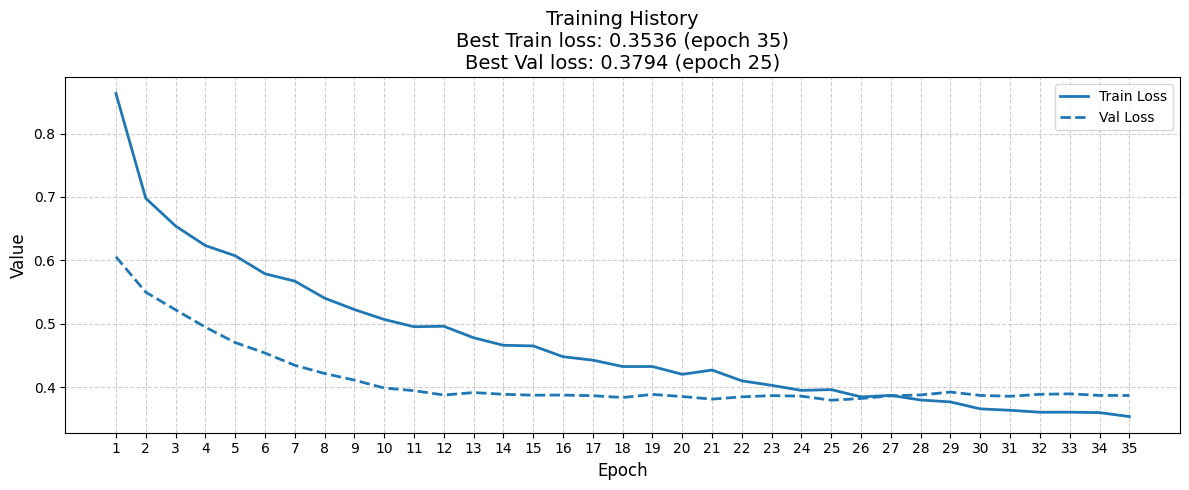

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=4,
        min_lr=1e-9,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed()
d_hist = d_model.fit(
    x=d_train,
    validation_data=d_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(d_hist)

- save the weights corresponding to the best validation loss

In [ ]:
l = min(d_hist.history['val_loss'])
f = os.path.join('.', 'multi-agent-models', 'lstm', 'daily')
d_model.save_weights(l, f, 'daily')

Weights saved at .\multi-agent-models\lstm\daily\daily_in24-22_emb64_head64-32_loss0-3794.h5


- model structure

In [400]:
d_model.summary()


Model: multi_agent_model_29
Layer (type)                       Output Shape                  Param #        
masking_29                          (None, 24, 22)                 0              
lstm_0                              (None, 64)                     22272          

PM10_head.dense_182                 (None, 64)                     4160           
PM10_head.dropout                   (None, 64)                     0              
PM10_head.dense_183                 (None, 32)                     2080           
PM10_head.dropout_1                 (None, 32)                     0              
PM10_head.dense_184                 (None, 1)                      33             

PM2.5_head.dense_185                (None, 64)                     4160           
PM2.5_head.dropout_2                (None, 64)                     0              
PM2.5_head.dense_186                (None, 32)                     2080           
PM2.5_head.dropout_3                (None, 32)            

#### **Results**

- We first predict the test set data

In [30]:
def map_inputs(x, a, *rest):
    return (x, a),

d_results = d_model.predict(d_test.map(map_inputs)) # only pass sequence and agent id

56/56 [==============================] - 2s 8ms/step


- Then, using the saved agent, station and date values, we group each agent prediction to the corresponding station.

In [31]:
d_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in d_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in d_agent_values['true']:
            d_agent_values['true'][s_key] = {}
            d_agent_values['predictions'][s_key] = {}
        if a_key not in d_agent_values['true'][s_key]:
            d_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            d_agent_values['true'][s_key][a_key].index.name = 'Date'
            d_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        d_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        d_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = d_results[i]
        i+=1

- visualize the results

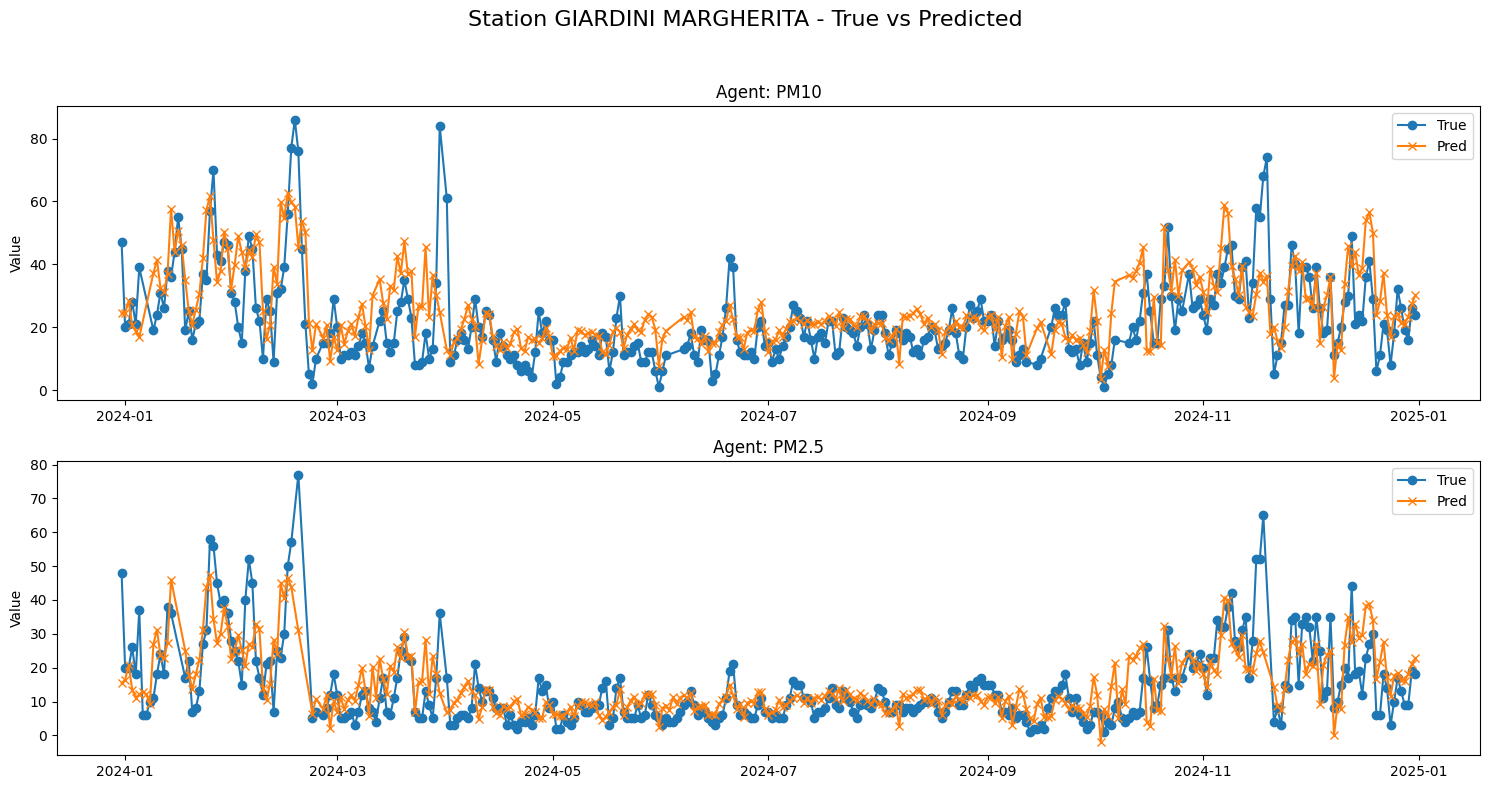

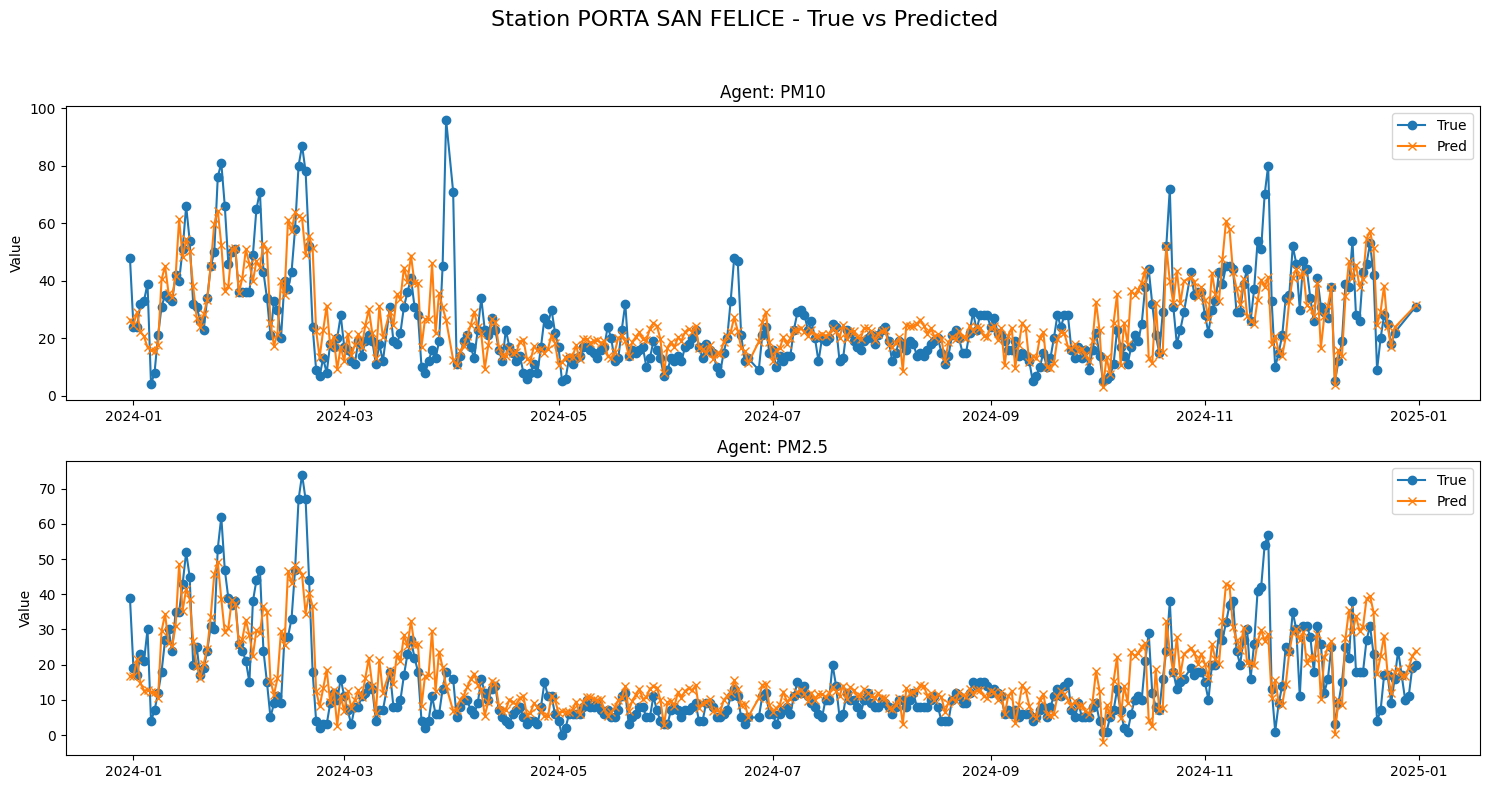

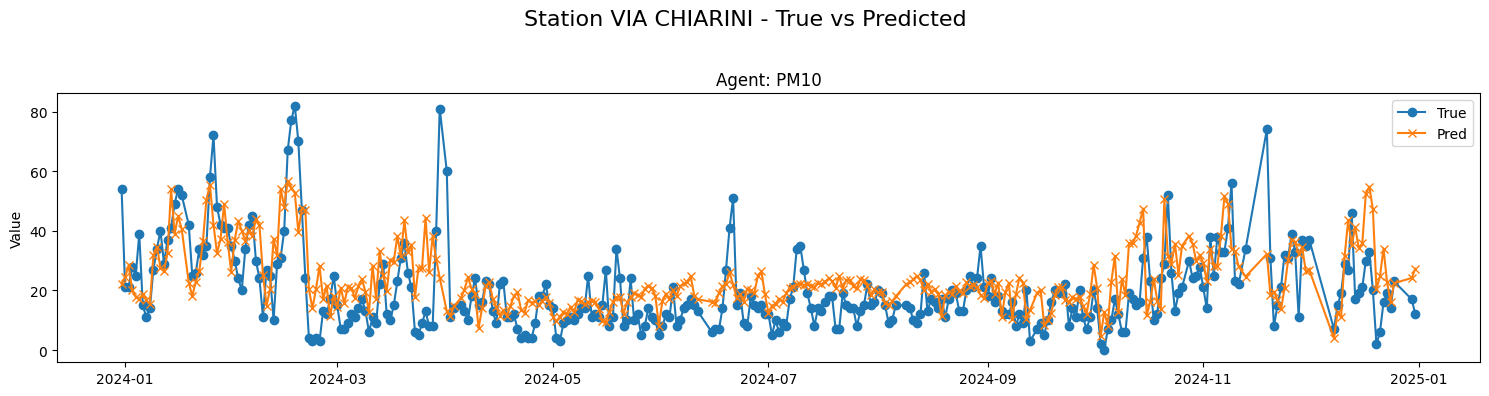

In [33]:
plot_predictions(d_agent_values, agent_distributions)

### **Hourly**

In [32]:
BATCH_SIZE = 32

h_train = h_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
h_val = h_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
h_test = h_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [33]:
lstm_units = (64, 64, 64)
head_hidden_units = (64, 32)

h_model = MultiAgentModel(
    input_shape=hourly_input_shape,
    task_ids=[agent for agent in agents if agent not in ('PM10','PM2.5')],
    lstm_units=lstm_units,
    head_hidden_units=head_hidden_units
)

h_model.compile(
    Adam(learning_rate=1e-4),
    loss="mse",       
    metrics=["mae"],  
    weighted_metrics=[]
)

In [34]:
h_model.evaluate(h_val.take(1)) # init the model
f = os.path.join('.', 'multi-agent-models', 'lstm', 'hourly')
h_model.load_weights(0.2251, f, 'hourly')

1/1 [==============================] - 5s 5s/step - loss: 2.3021 - mae: 1.2034
Trying to load .\multi-agent-models\lstm\hourly\hourly_in3-24_emb64-64-64_head64-32_loss0-2251.h5


Epoch 1/100
8388/8388 [==============================] - 183s 14ms/step - loss: 0.4061 - mae: 0.4574 - val_loss: 0.3473 - val_mae: 0.4264 - lr: 1.0000e-04
Epoch 2/100
8388/8388 [==============================] - 171s 14ms/step - loss: 0.3668 - mae: 0.4312 - val_loss: 0.3321 - val_mae: 0.4116 - lr: 1.0000e-04
Epoch 3/100
8388/8388 [==============================] - 174s 14ms/step - loss: 0.3530 - mae: 0.4223 - val_loss: 0.3210 - val_mae: 0.4058 - lr: 1.0000e-04
Epoch 4/100
8388/8388 [==============================] - 175s 14ms/step - loss: 0.3435 - mae: 0.4156 - val_loss: 0.3164 - val_mae: 0.4052 - lr: 1.0000e-04
Epoch 5/100
8388/8388 [==============================] - 174s 14ms/step - loss: 0.3357 - mae: 0.4104 - val_loss: 0.3082 - val_mae: 0.4028 - lr: 1.0000e-04
Epoch 6/100
8388/8388 [==============================] - 179s 15ms/step - loss: 0.3298 - mae: 0.4067 - val_loss: 0.3045 - val_mae: 0.3989 - lr: 1.0000e-04
Epoch 7/100
8388/8388 [==============================] - 182s 15ms/ste

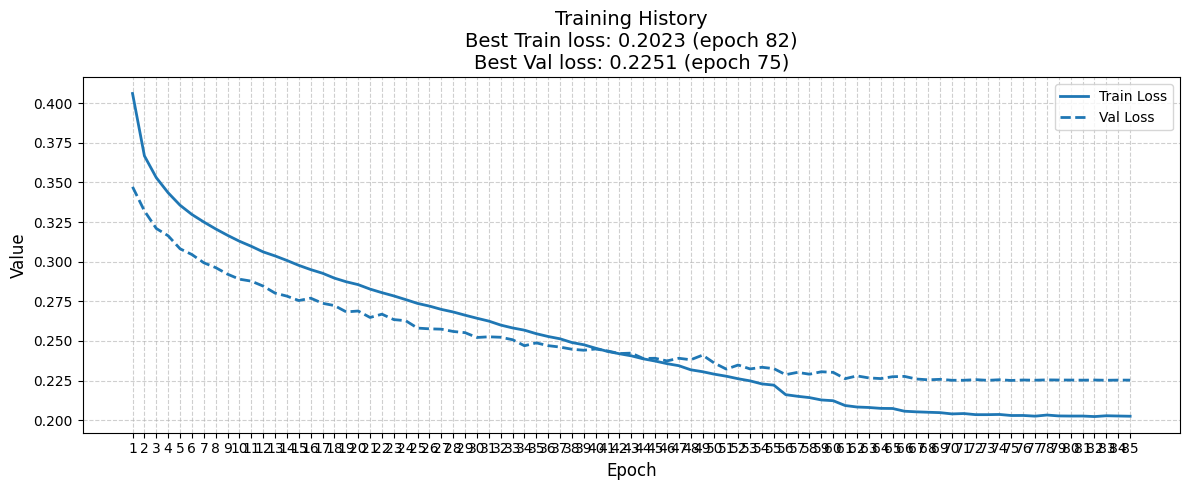

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=4,
        min_lr=1e-9,
        verbose=1,
        min_delta=0.001
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )
]

set_random_seed()
h_hist = h_model.fit(
    x=h_train,
    validation_data=h_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(h_hist)

In [ ]:
l = min(h_hist.history['val_loss'])
f = os.path.join('.', 'multi-agent-models', 'lstm', 'hourly')
h_model.save_weights(l, f, 'hourly')

Weights saved at .\multi-agent-models\lstm\hourly\hourly_in3-24_emb64-64-64_head64-32_loss0-2251.h5


In [35]:
h_model.summary()


Model: multi_agent_model_1
Layer (type)                       Output Shape                  Param #        
masking_1                           (None, 3, 24)                  0              
lstm_0                              (None, 3, 64)                  22784          
lstm_1                              (None, 3, 64)                  33024          
lstm_2                              (None, 64)                     33024          

C6H6_head.dense_6                   (None, 64)                     4160           
C6H6_head.dropout_4                 (None, 64)                     0              
C6H6_head.dense_7                   (None, 32)                     2080           
C6H6_head.dropout_5                 (None, 32)                     0              
C6H6_head.dense_8                   (None, 1)                      33             

CO_head.dense_9                     (None, 64)                     4160           
CO_head.dropout_6                   (None, 64)             

In [36]:
def map_inputs(x, a, *rest):
    return (x, a),

h_results = h_model.predict(h_test.map(map_inputs)) # only pass sequence and agent id

1886/1886 [==============================] - 21s 9ms/step


In [37]:
h_agent_values = {
    'true': {},
    'predictions': {}
}
i = 0

for _, agent_ids, targets, station_ids, dates in h_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s, d in zip(agent_ids, targets, station_ids, dates):
        s_key = stations[s]
        a_key = a.decode('utf-8')
        if s_key not in h_agent_values['true']:
            h_agent_values['true'][s_key] = {}
            h_agent_values['predictions'][s_key] = {}
        if a_key not in h_agent_values['true'][s_key]:
            h_agent_values['true'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['predictions'][s_key][a_key] = pd.DataFrame(columns=['Agent_value'])
            h_agent_values['true'][s_key][a_key].index.name = 'Date'
            h_agent_values['predictions'][s_key][a_key].index.name = 'Date'
        
        date_index = d.numpy().decode('utf-8')
        h_agent_values['true'][s_key][a_key].loc[pd.to_datetime(date_index)] = t
        h_agent_values['predictions'][s_key][a_key].loc[pd.to_datetime(date_index)] = h_results[i]
        i+=1

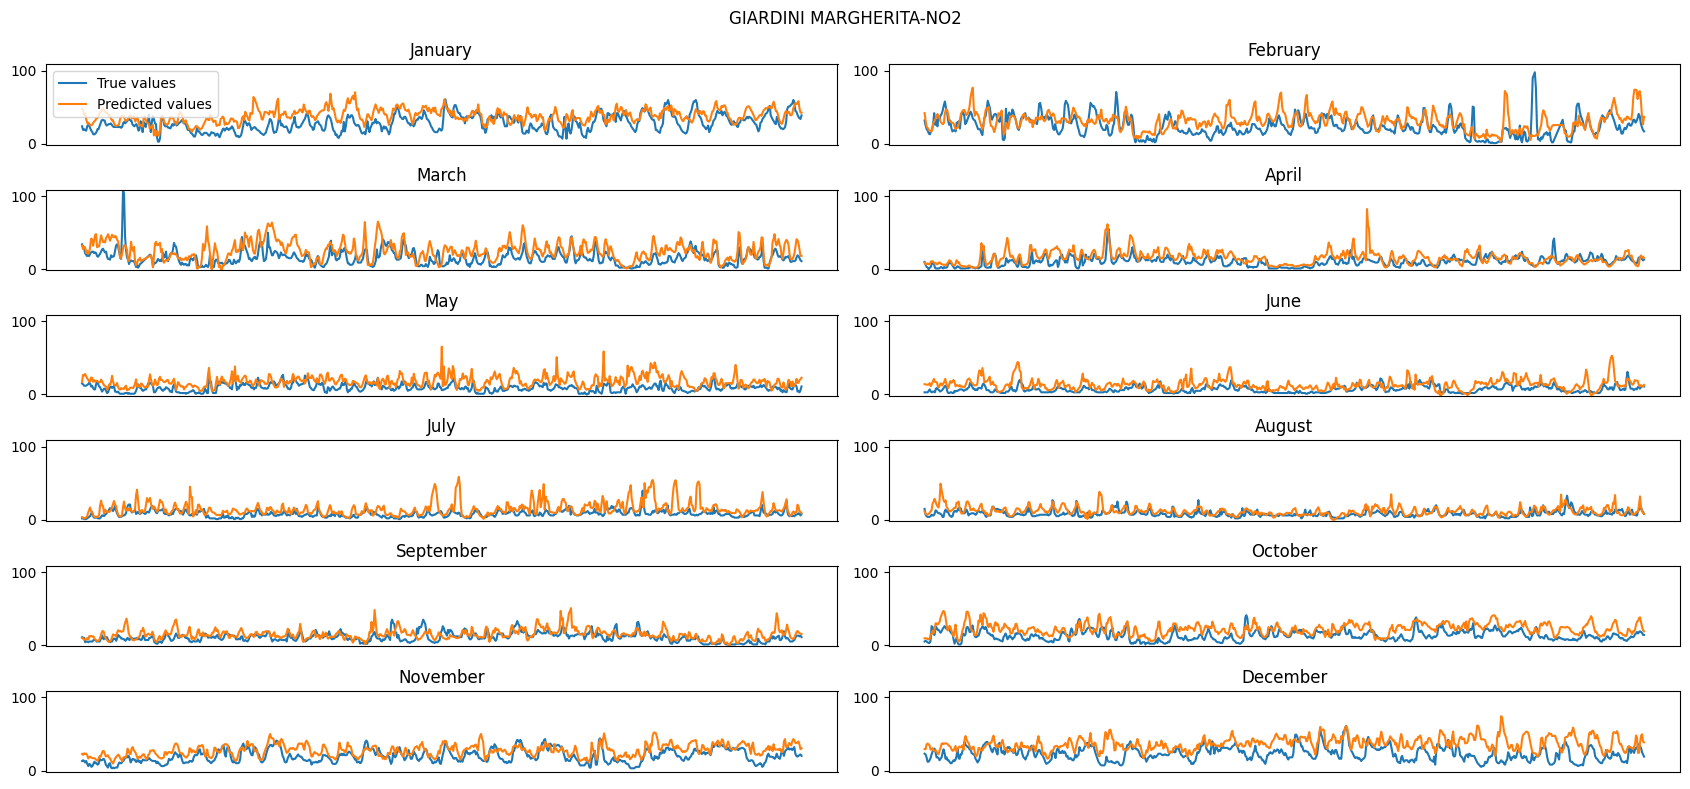

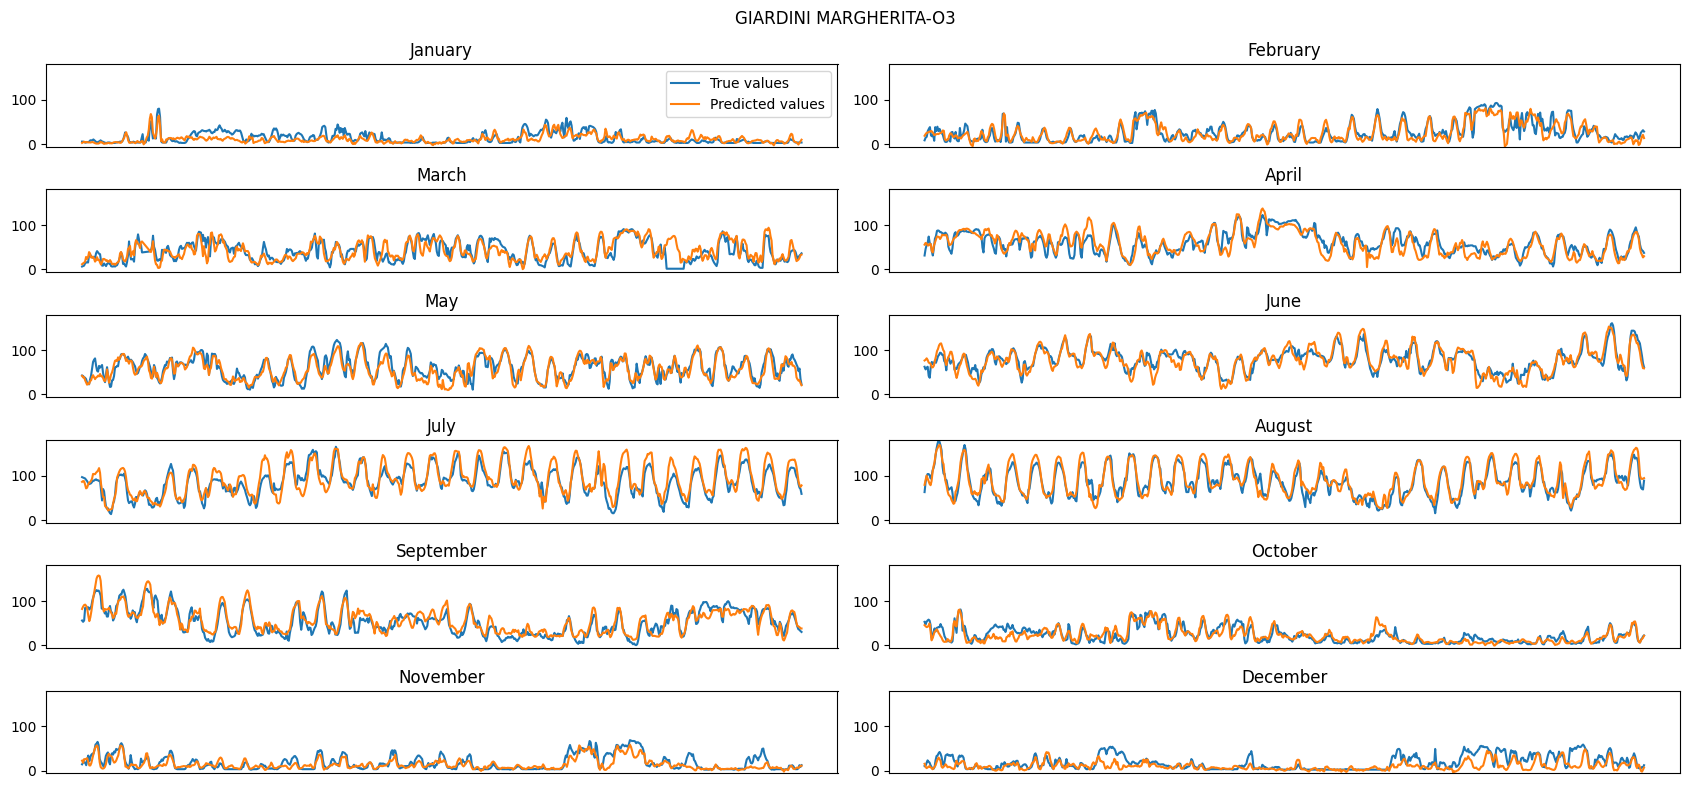

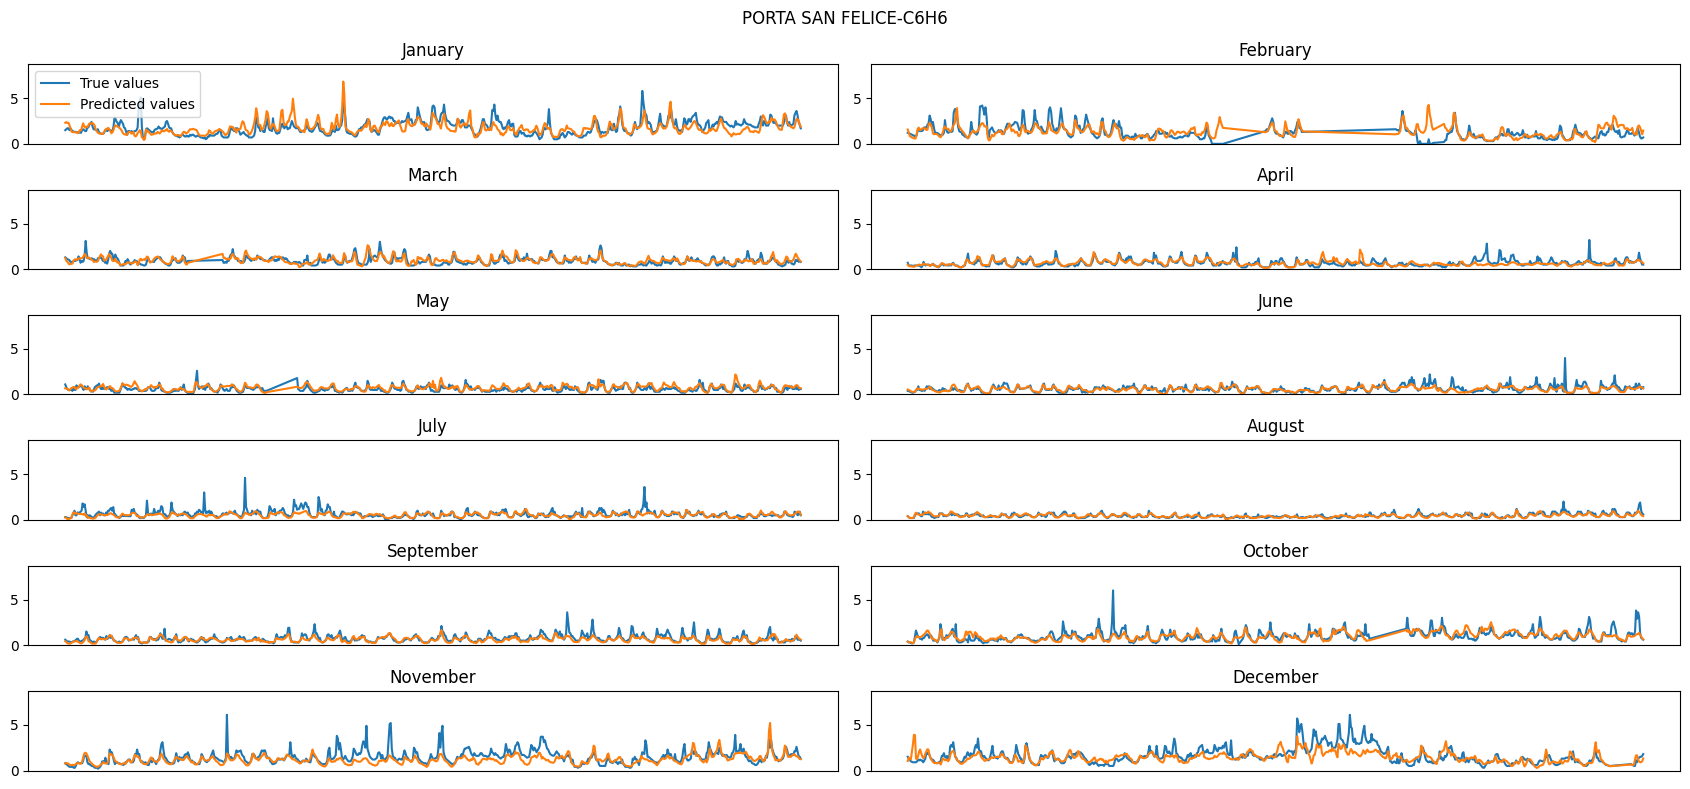

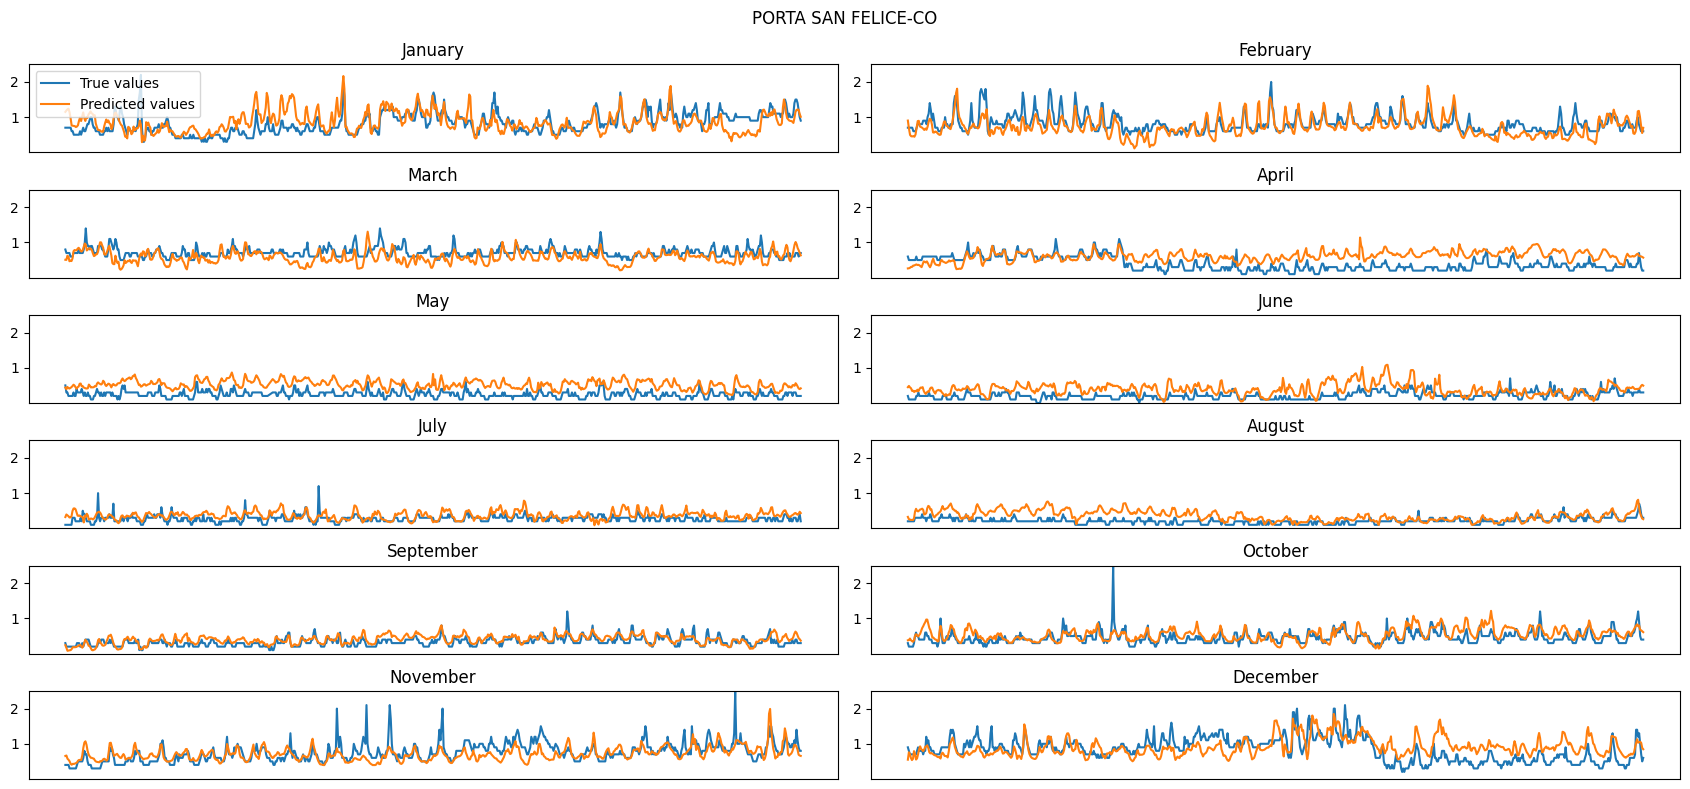

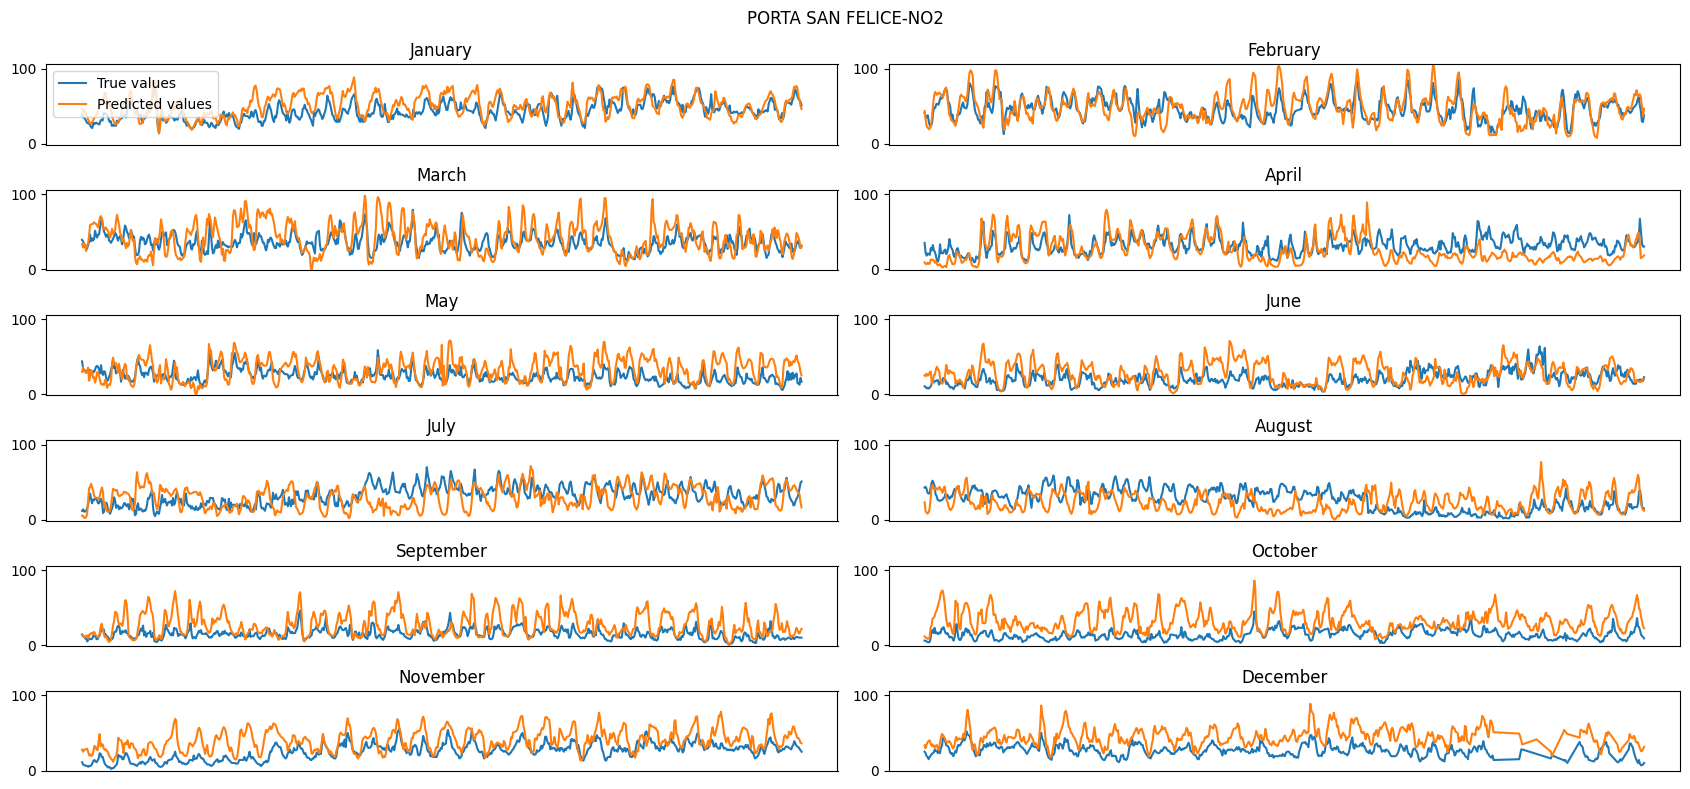

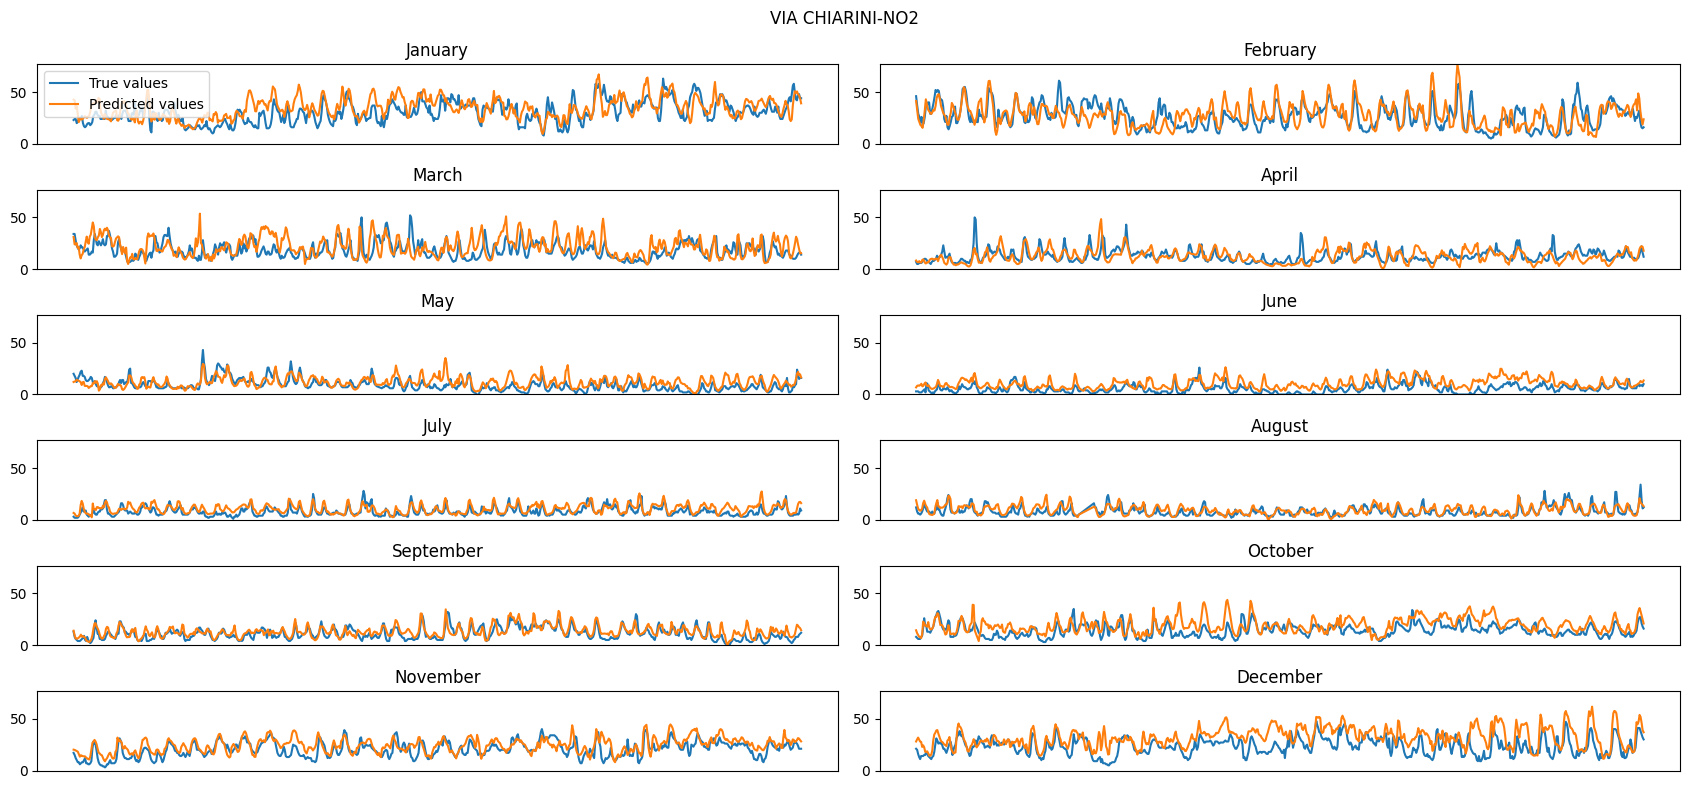

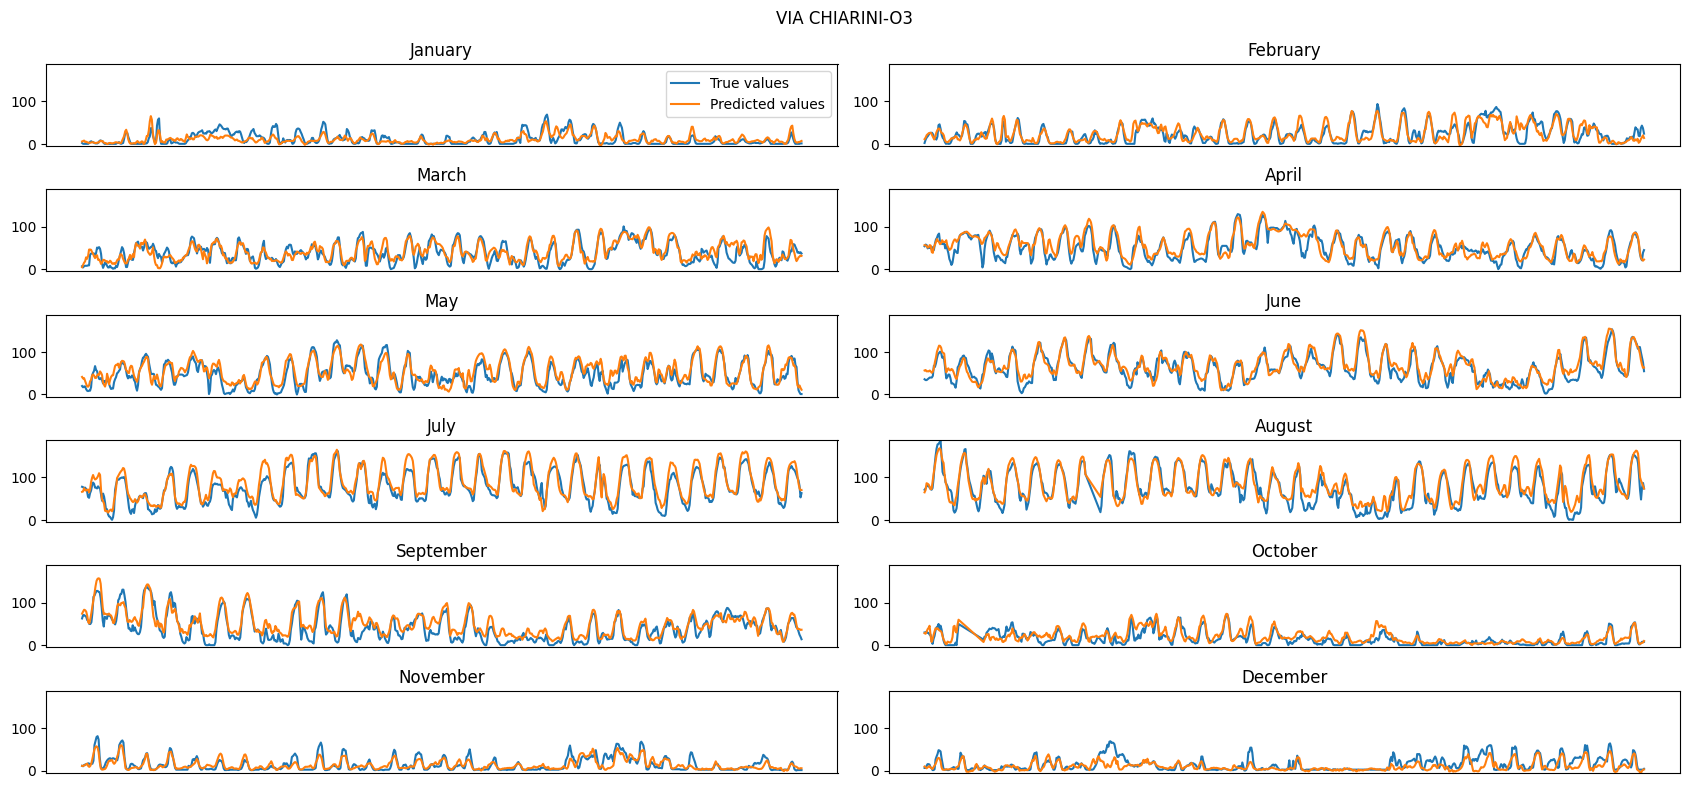

In [39]:
plot_predictions(
    h_agent_values, 
    agent_distributions,
    show_months=True
)

## **Air Quality Index**

### **AQI calculation**

Compute the AQI values using the same techniques seen earlier. Before that we merge all the results.

In [38]:
agent_values = {
    'predictions': {},
    'true': {}
}
# we should merge here the results of the two models, such to have a singular dict for every station
for station in stations:
    agent_values['predictions'][station] = {}
    agent_values['true'][station] = {}
    for agent in h_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (h_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (h_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed
    for agent in d_agent_values['predictions'][station]:
        agent_values['predictions'][station][agent] = (d_agent_values['predictions'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0)
        agent_values['true'][station][agent] = (d_agent_values['true'][station][agent] * agent_distributions[agent][1] + agent_distributions[agent][1]).clip(lower=0) # should not be needed

for station in stations:
    print(
          f"{station}:\n"
          f"  preds: {agent_values['predictions'][station].keys()}\n"
          f"  true: {agent_values['true'][station].keys()}"
    )
    for a in agent_values['predictions'][station]:
        if len(agent_values['predictions'][station][a]) != len(agent_values['true'][station][a]):
            print(f'Inconsistent lenghts for {a} in {station}')

GIARDINI MARGHERITA:
  preds: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
  true: dict_keys(['NO2', 'O3', 'PM10', 'PM2.5'])
PORTA SAN FELICE:
  preds: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
  true: dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
VIA CHIARINI:
  preds: dict_keys(['NO2', 'O3', 'PM10'])
  true: dict_keys(['NO2', 'O3', 'PM10'])


- get hourly and daily AQIs

In [39]:
predictions = agent_values['predictions']
true_values = agent_values['true']

pred_AQIs_daily = {s: {agent: get_AQI(predictions[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')
pred_AQIs_hourly = {s: {agent: get_AQI(predictions[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in predictions[s].keys()} for s in predictions}
pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')
true_AQIs_daily = {s: {agent: get_AQI(true_values[s][agent], agent=agent, period='day', value_column='Agent_value',) for agent in true_values[s].keys()} for s in true_values}
true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')
true_AQIs_hourly = {s: {agent: get_AQI(true_values[s][agent],agent=agent,period='hour', value_column='Agent_value',include_hourly_pm=False) for agent in true_values[s].keys()} for s in true_values}
true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')
AQI_diff_daily = {}
AQI_diff_hourly = {}
for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

### **Hourly**

Station GIARDINI MARGHERITA AQI:


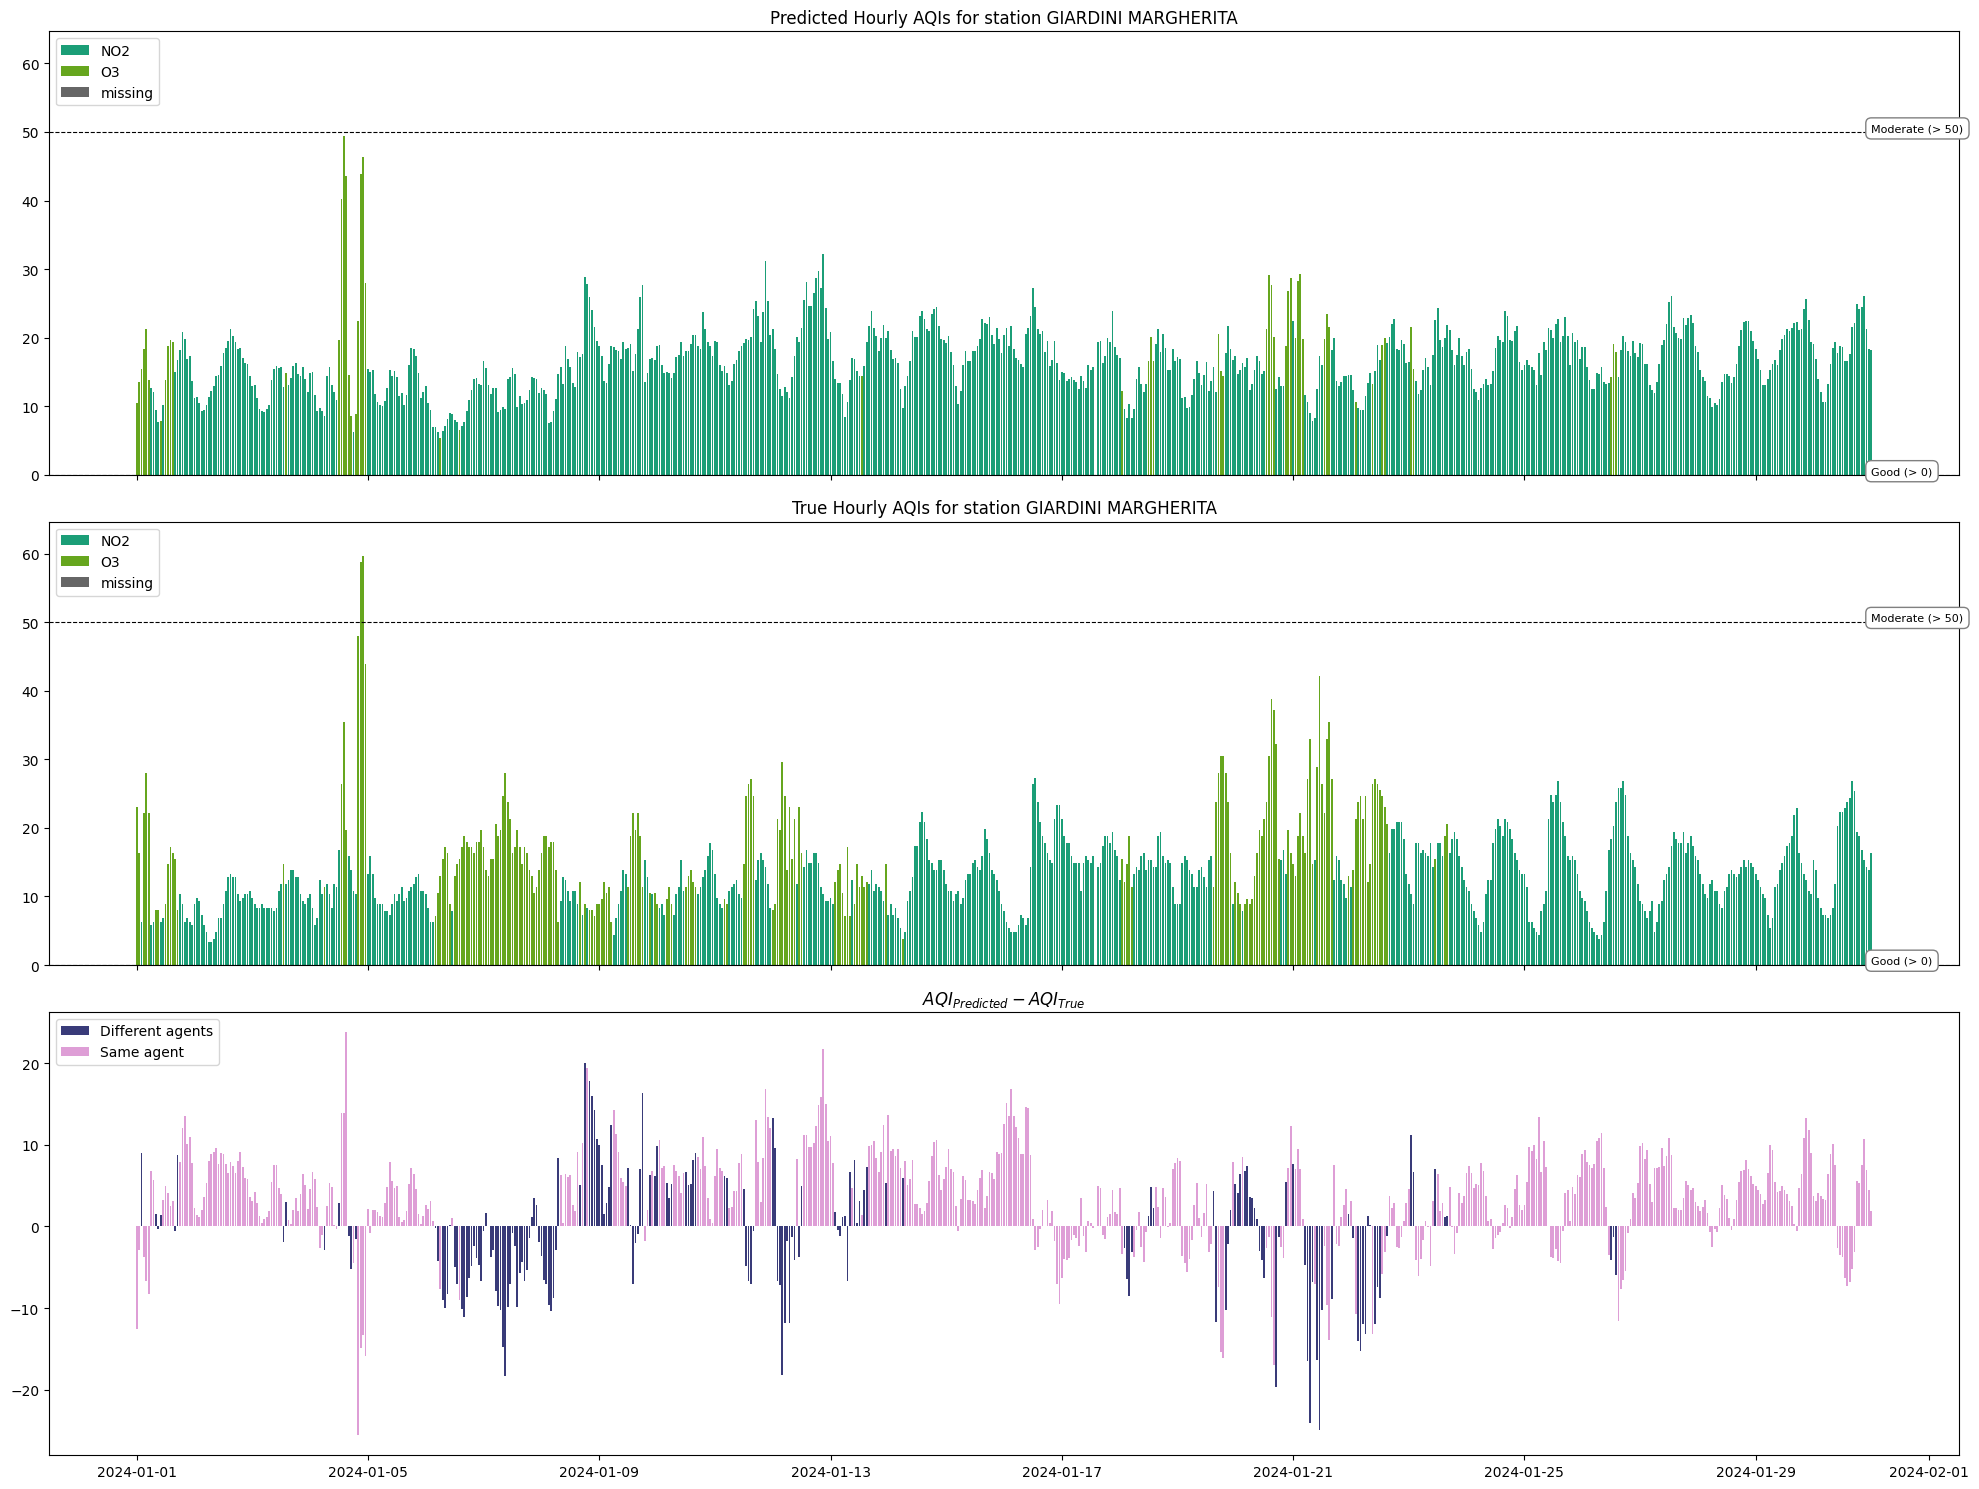

Station PORTA SAN FELICE AQI:


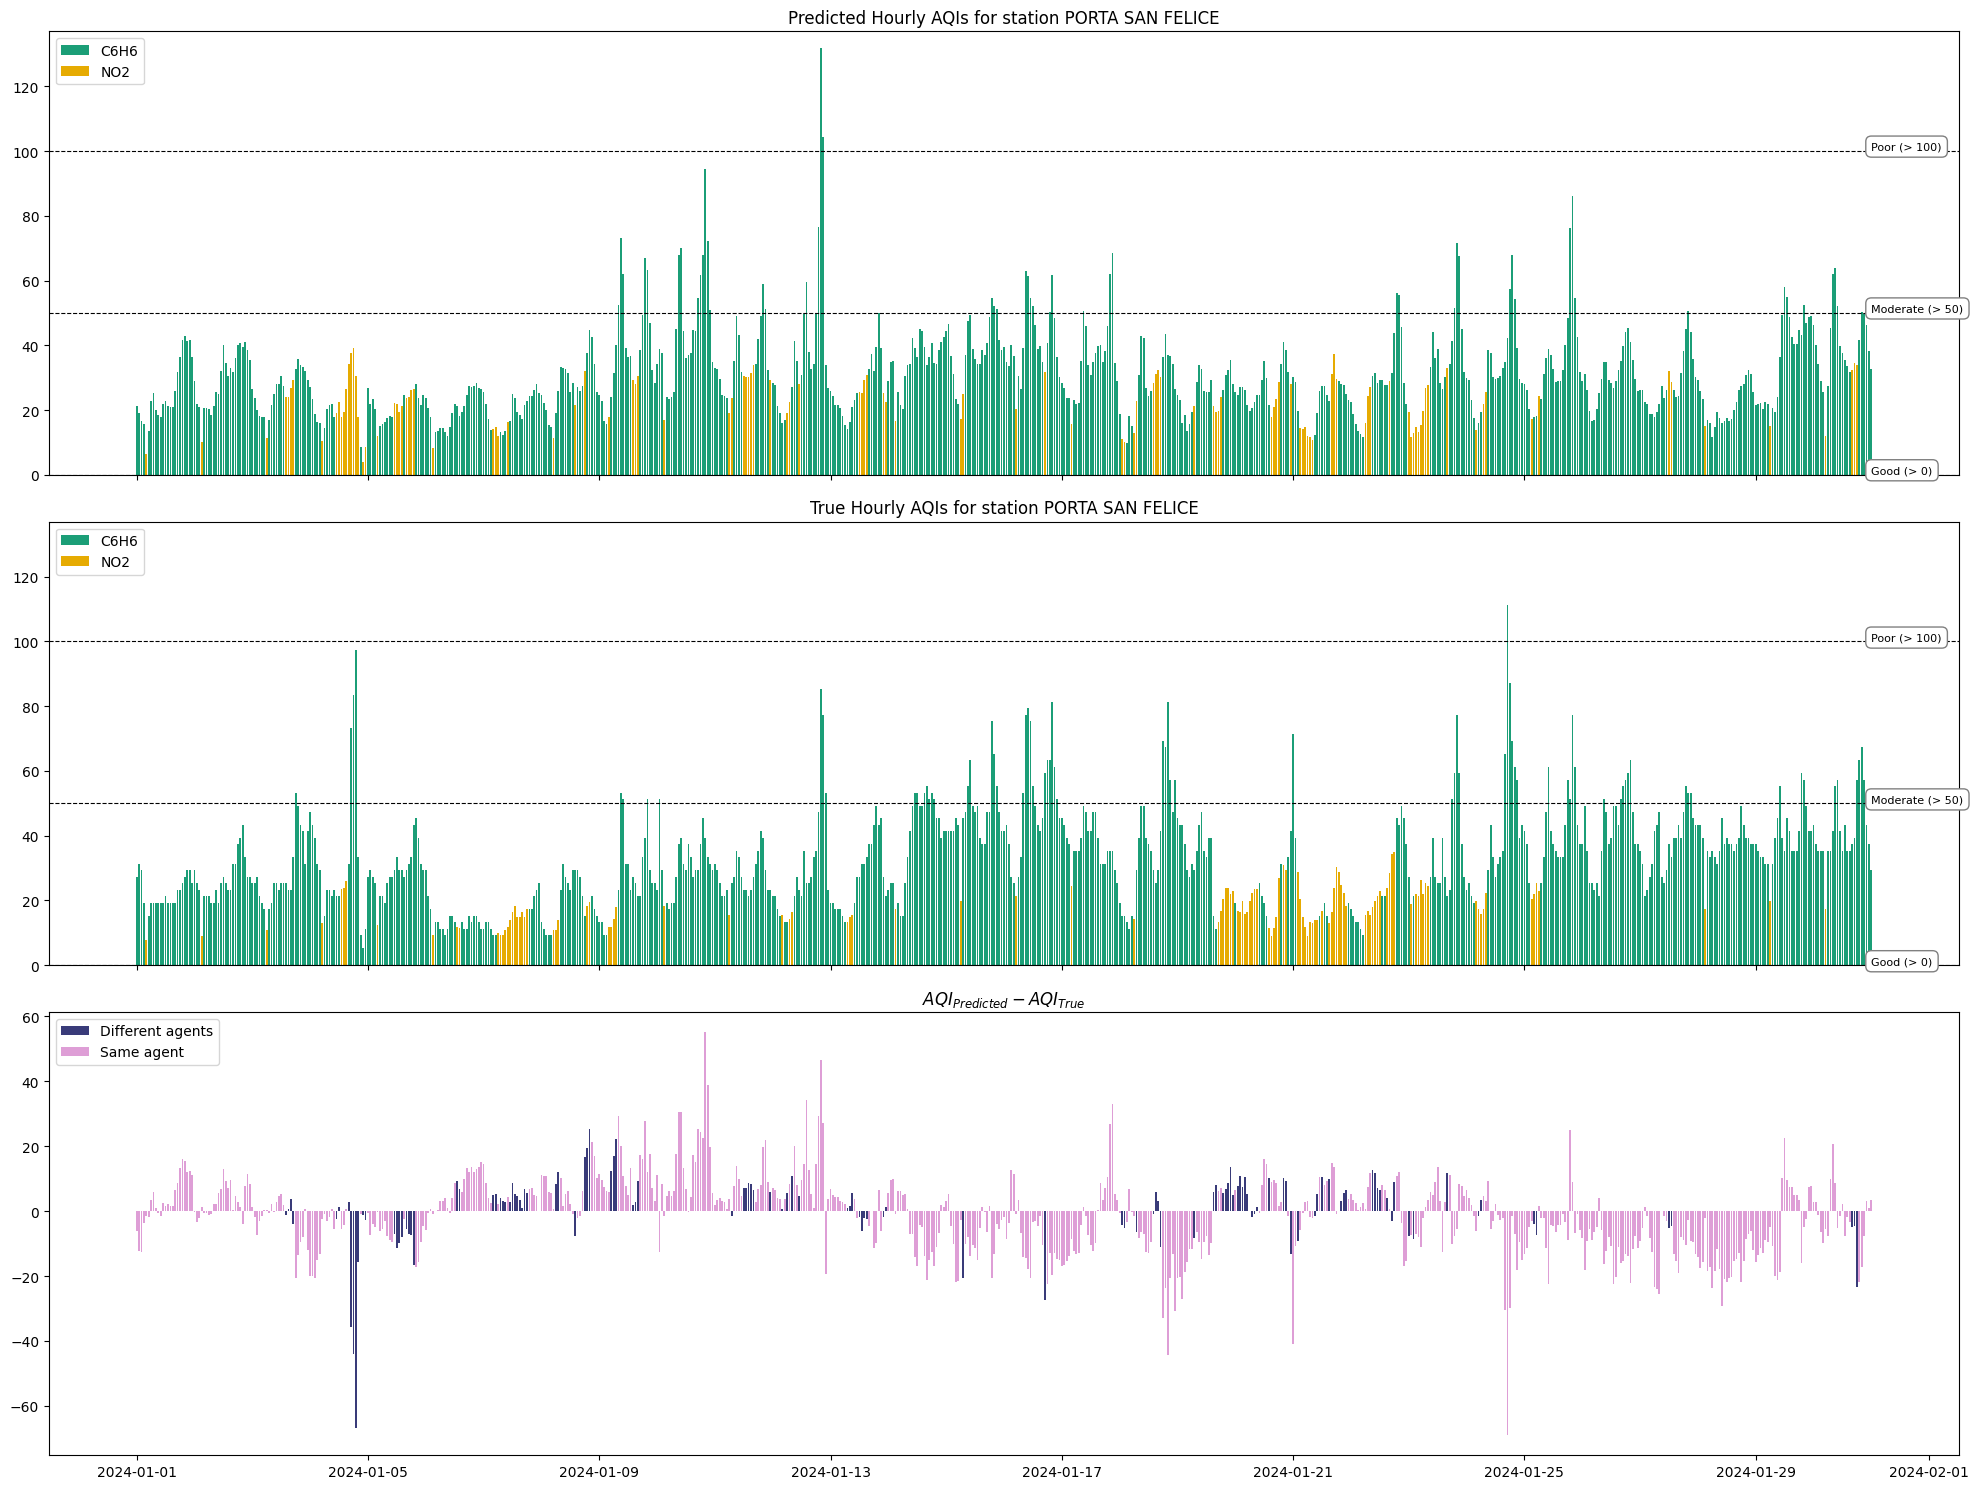

Station VIA CHIARINI AQI:


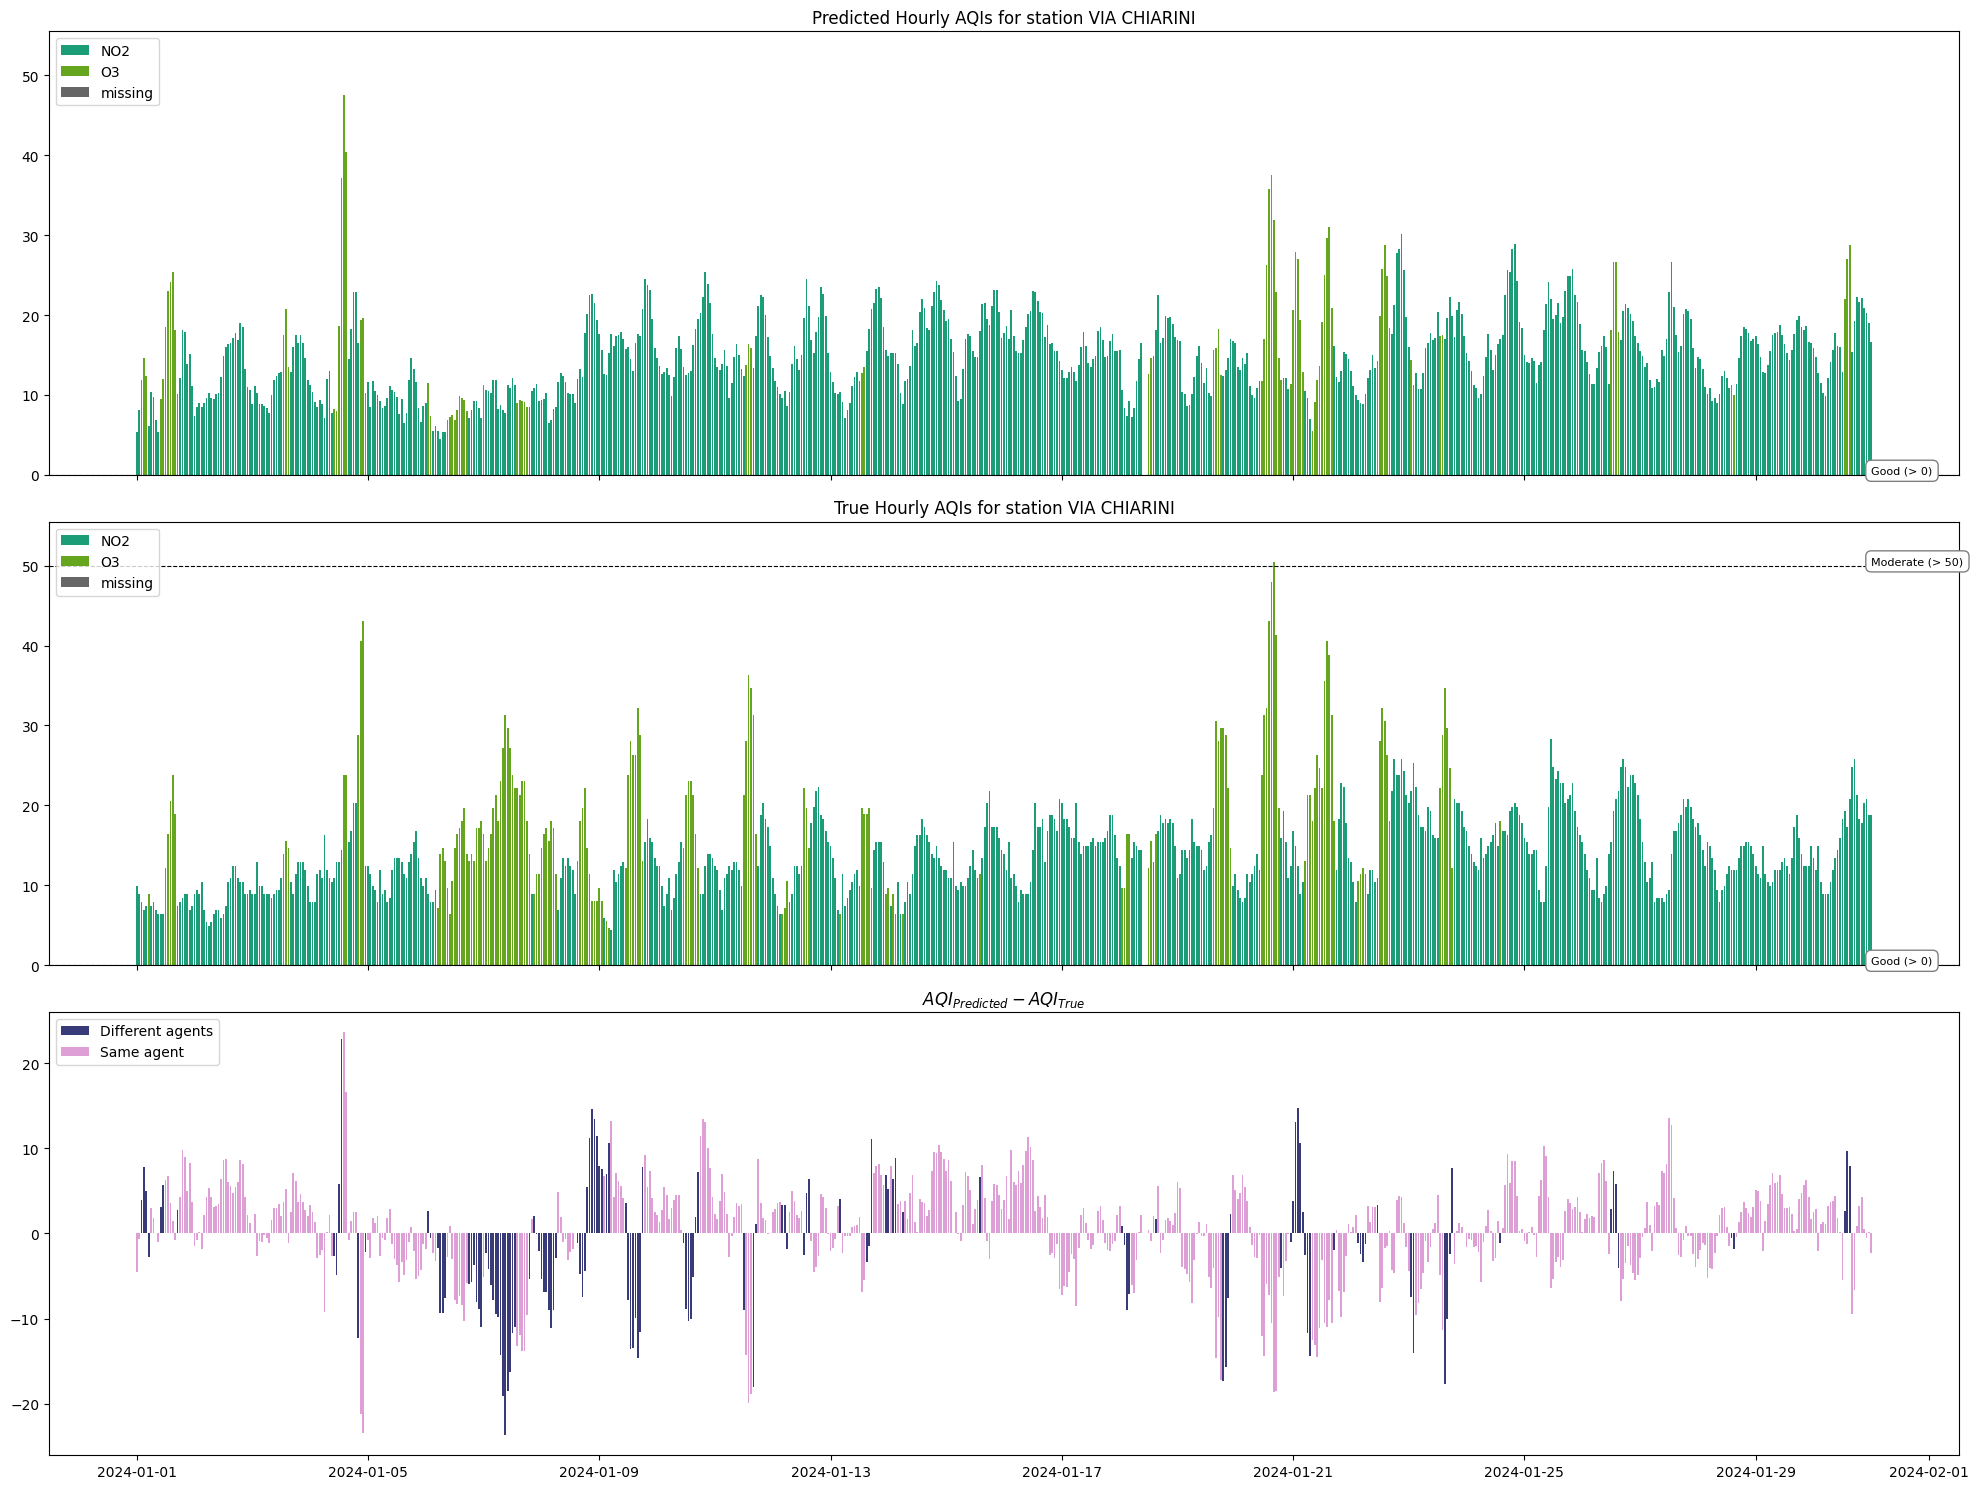

In [40]:
start=datetime(2024,1,1)
end=datetime(2024,1,31)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        categories=AQI_CATEGORIES,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA Hourly


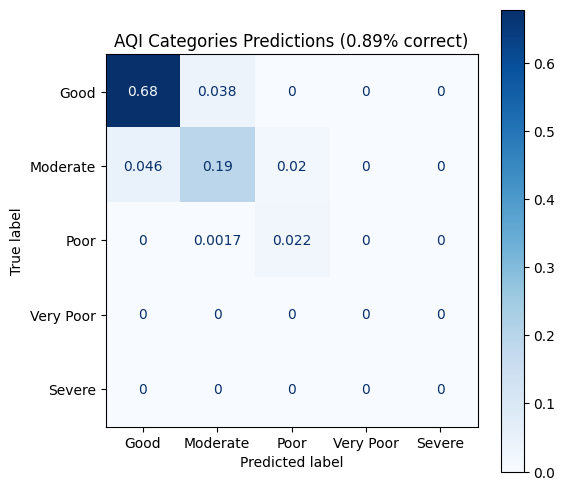

---------------------------------------------
> Absolute Mean AQI Difference: 8.07
> Positive Average AQI Difference: 7.91
> Negative Average AQI Difference: -8.30
> Percentage of Positive Differences: 59.18%
> Percentage of Negative Differences: 40.60%
> Percentage of Agent Values:
   - Same agent: 86.27
   - Different agents: 13.73
Station PORTA SAN FELICE Hourly


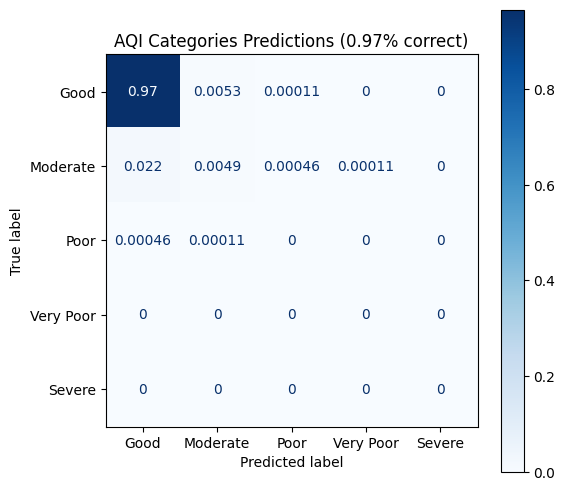

---------------------------------------------
> Absolute Mean AQI Difference: 6.83
> Positive Average AQI Difference: 6.32
> Negative Average AQI Difference: -7.41
> Percentage of Positive Differences: 52.63%
> Percentage of Negative Differences: 47.06%
> Percentage of Agent Values:
   - Same agent: 64.32
   - Different agents: 35.68
Station VIA CHIARINI Hourly


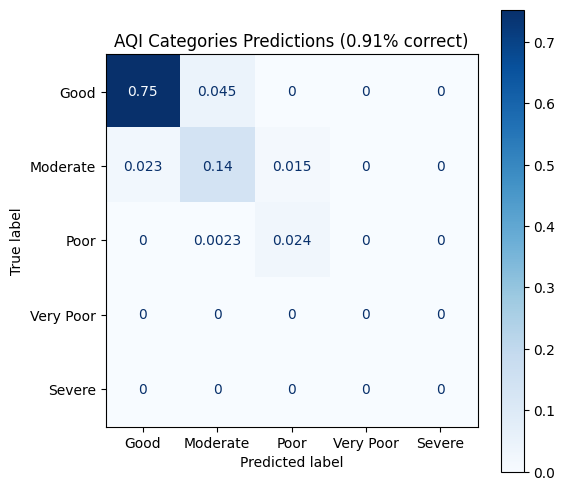

---------------------------------------------
> Absolute Mean AQI Difference: 7.77
> Positive Average AQI Difference: 8.36
> Negative Average AQI Difference: -6.63
> Percentage of Positive Differences: 65.86%
> Percentage of Negative Differences: 33.77%
> Percentage of Agent Values:
   - Same agent: 85.98
   - Different agents: 14.02


In [41]:
for station in pred_AQI_hourly:
    print('=============================================')
    print(f'Station {station} Hourly')
    print('=============================================')
    print_AQI_category_comparison(
        pred_AQI_hourly[station], 
        true_AQI_hourly[station], 
        categories=AQI_CATEGORIES,
    )
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_hourly[station])
    print('=============================================')

We obtained almost identical results, but this is not so surprising given that most of the hours have the same AQI category.

### **Daily**

Station GIARDINI MARGHERITA AQI:


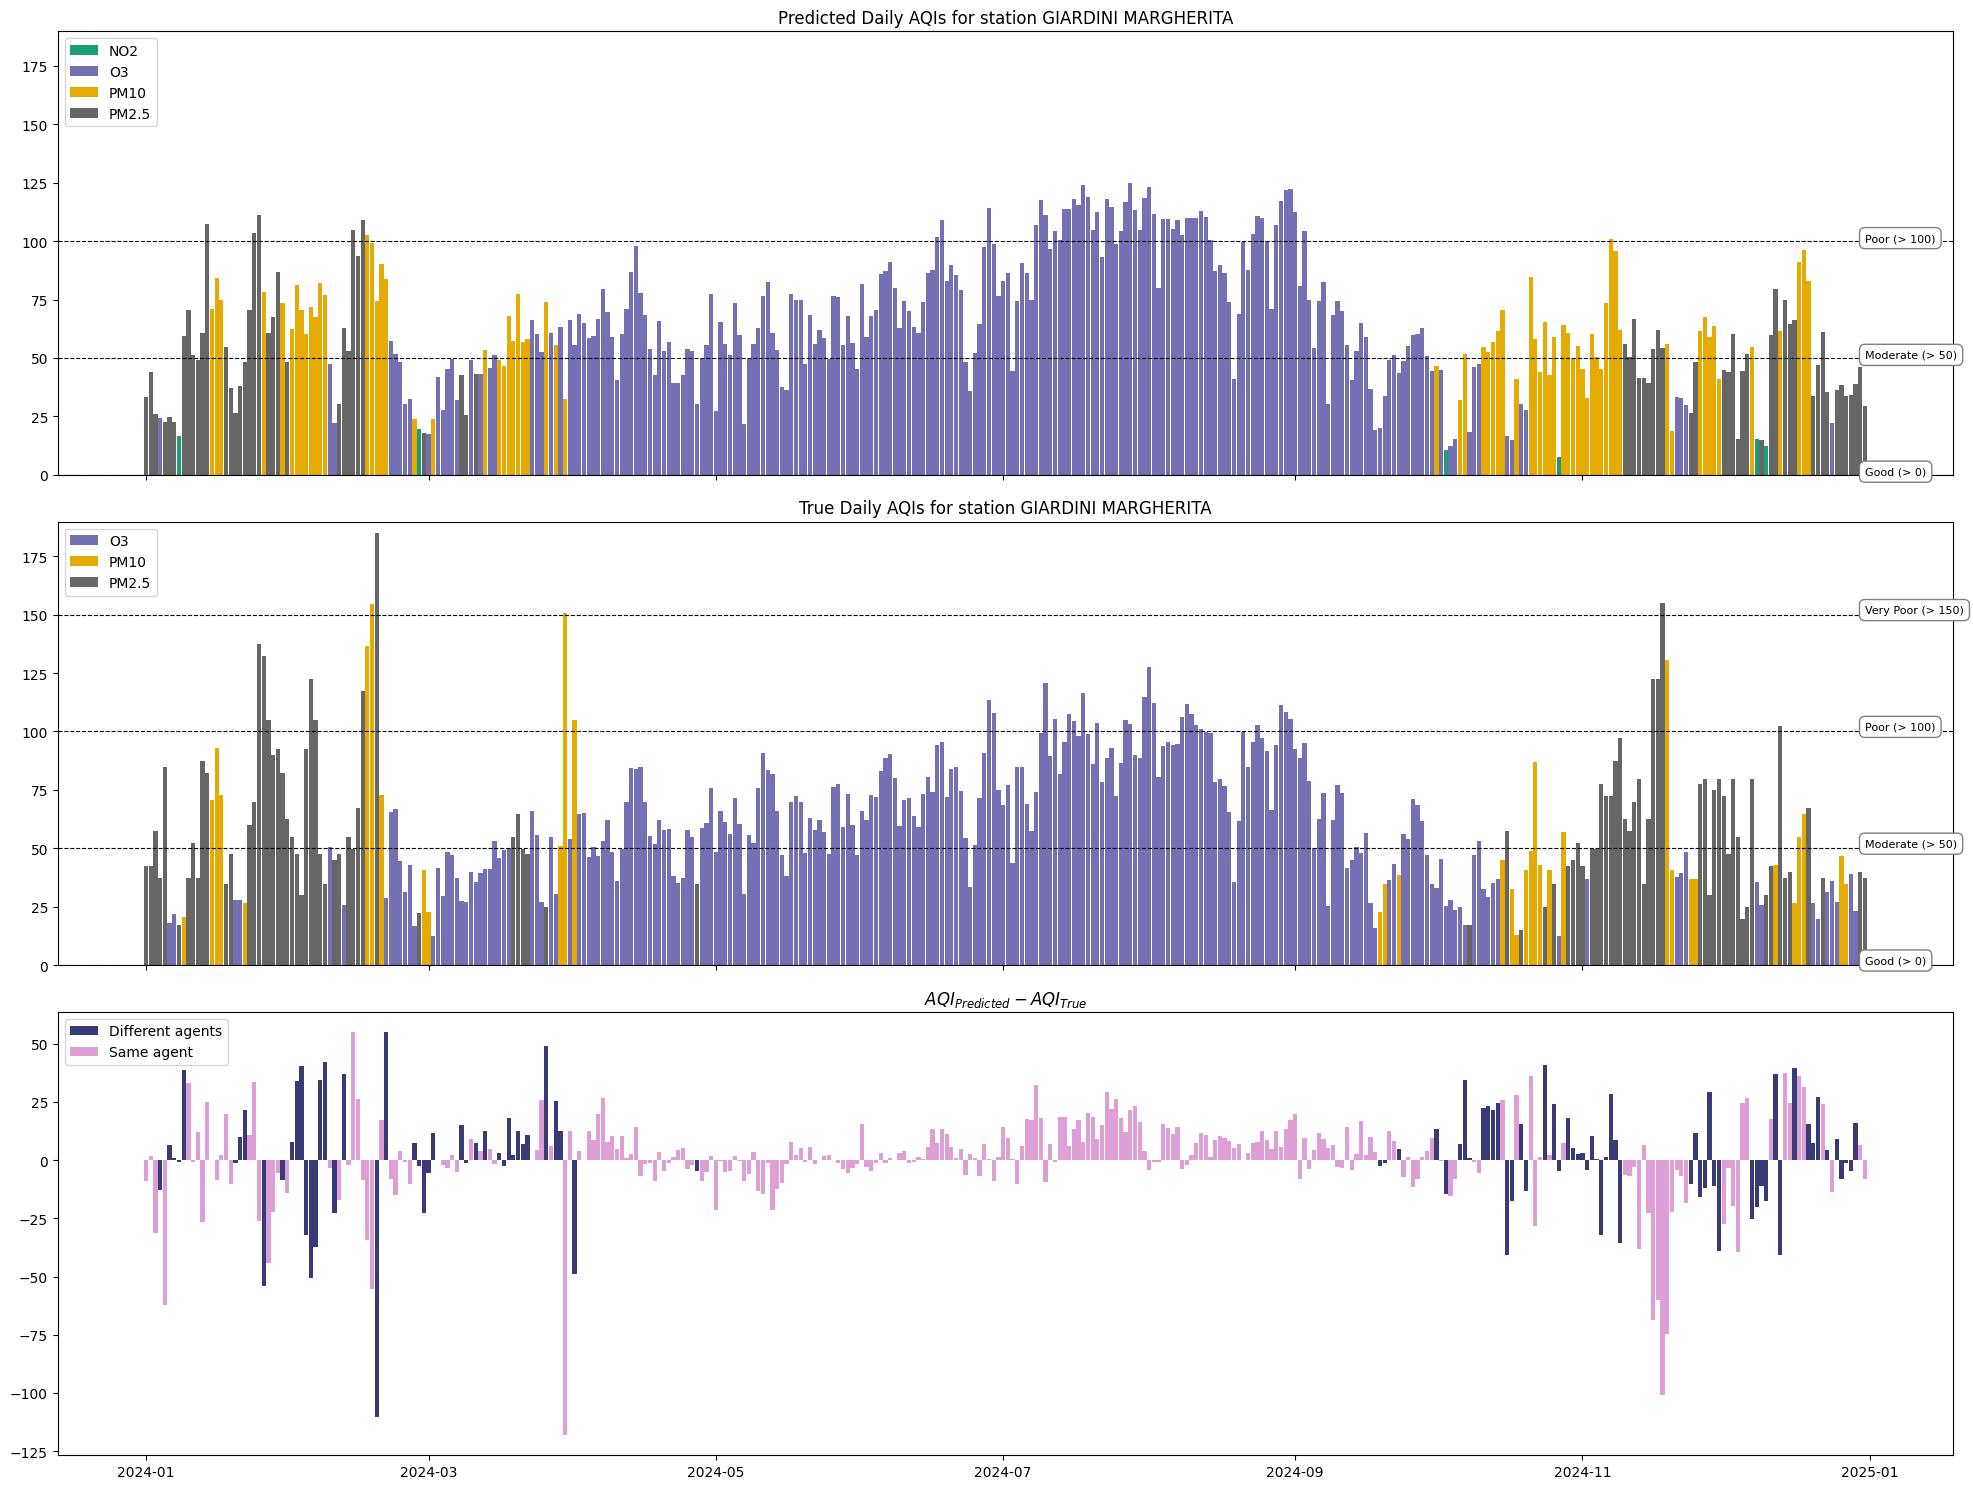

Station PORTA SAN FELICE AQI:


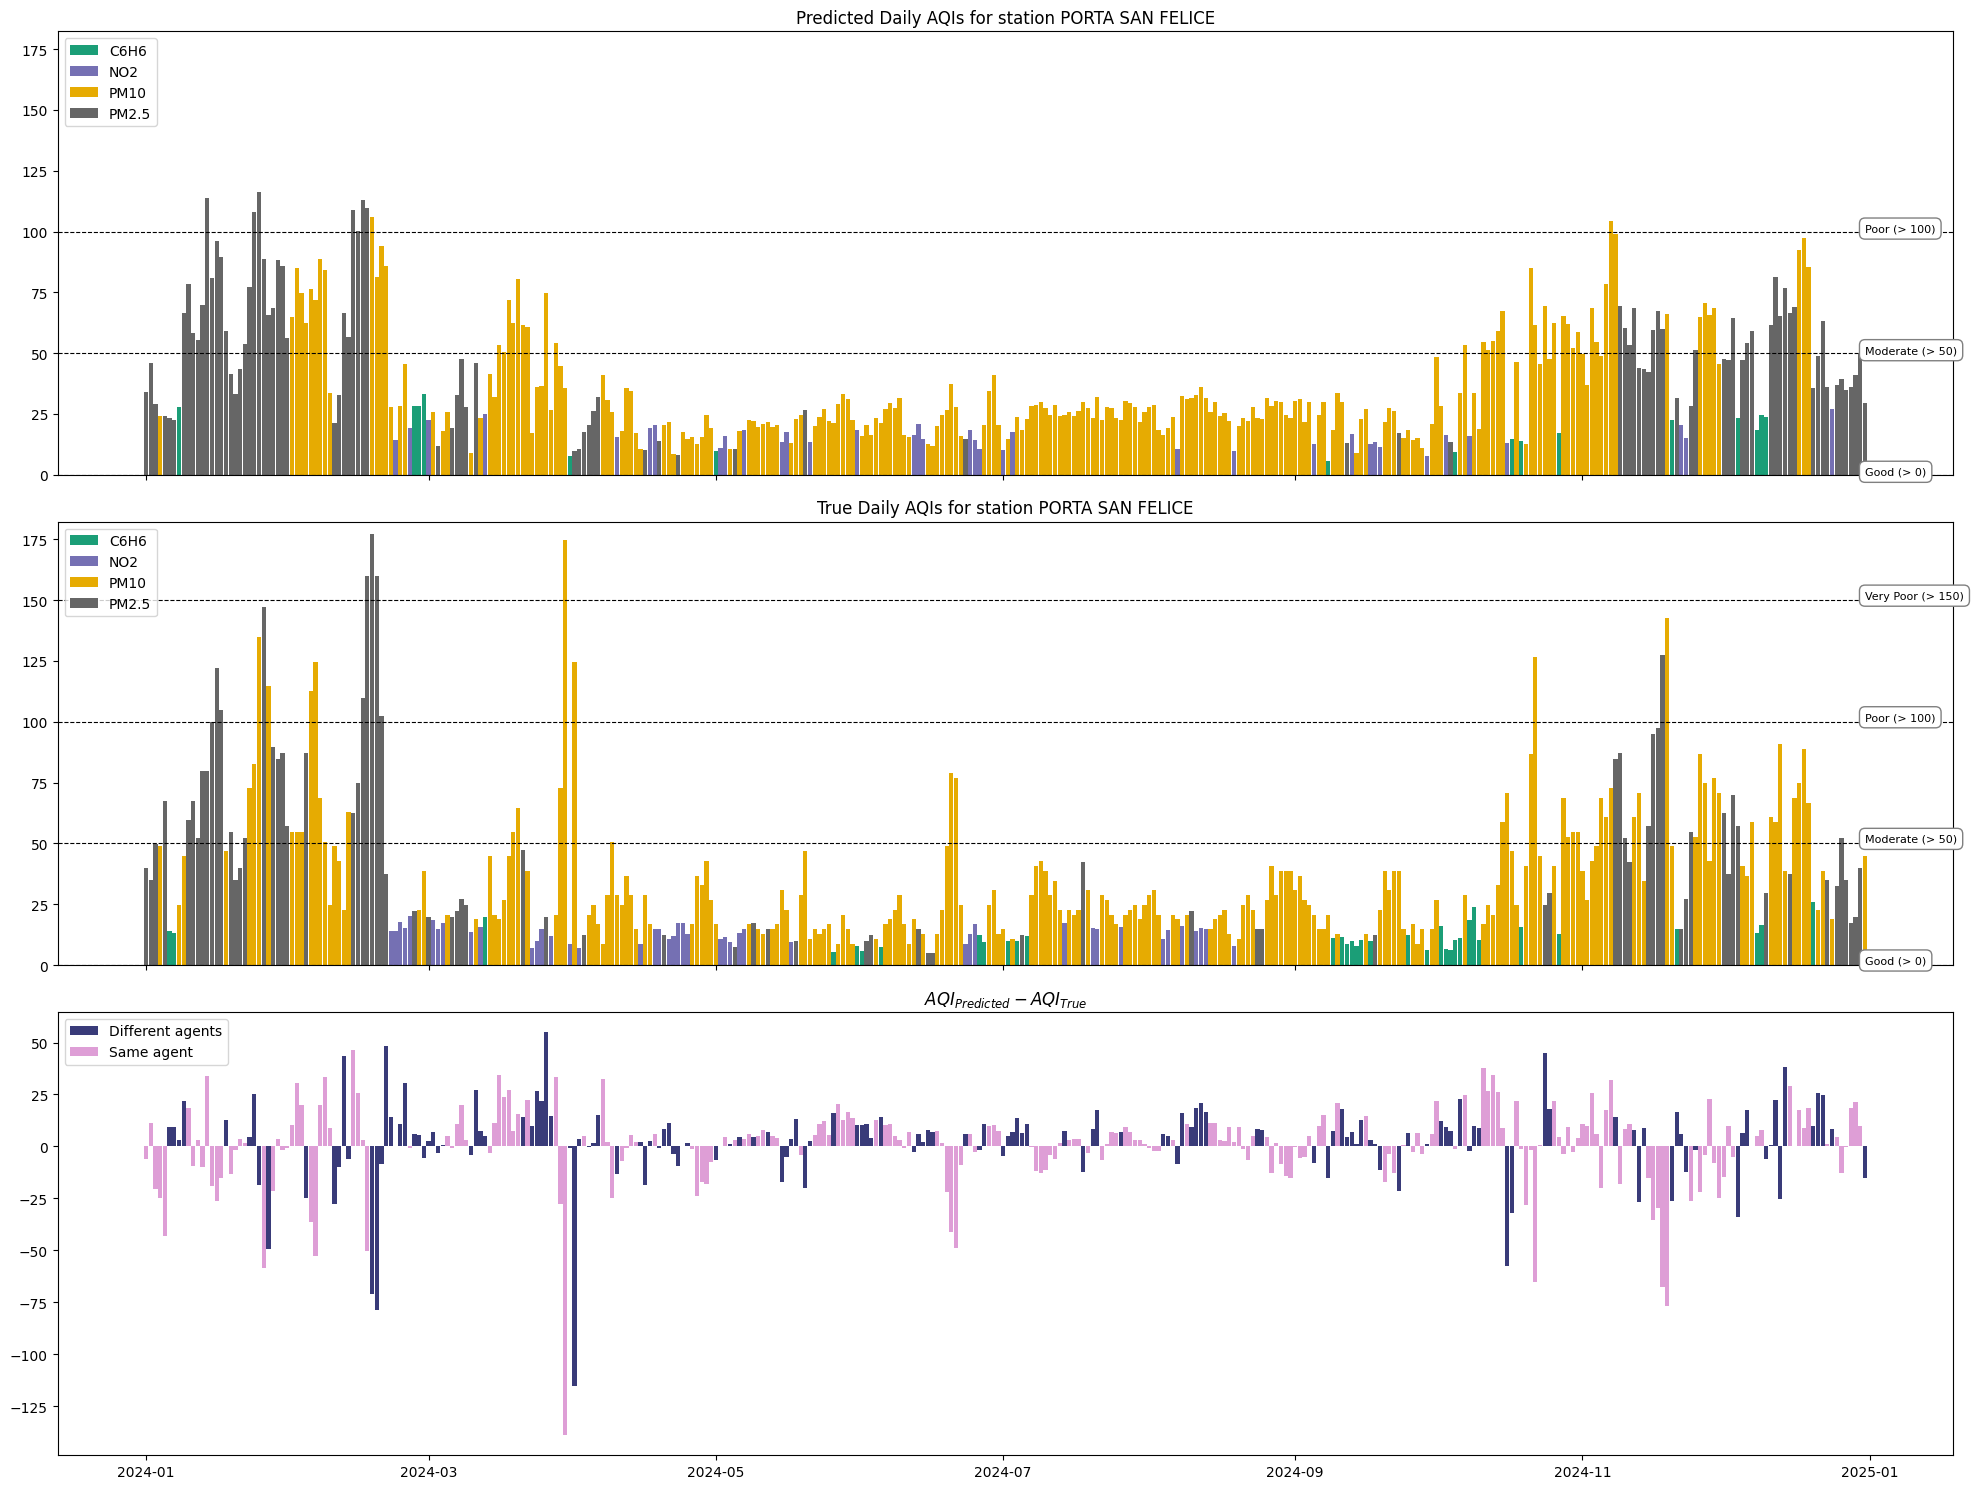

Station VIA CHIARINI AQI:


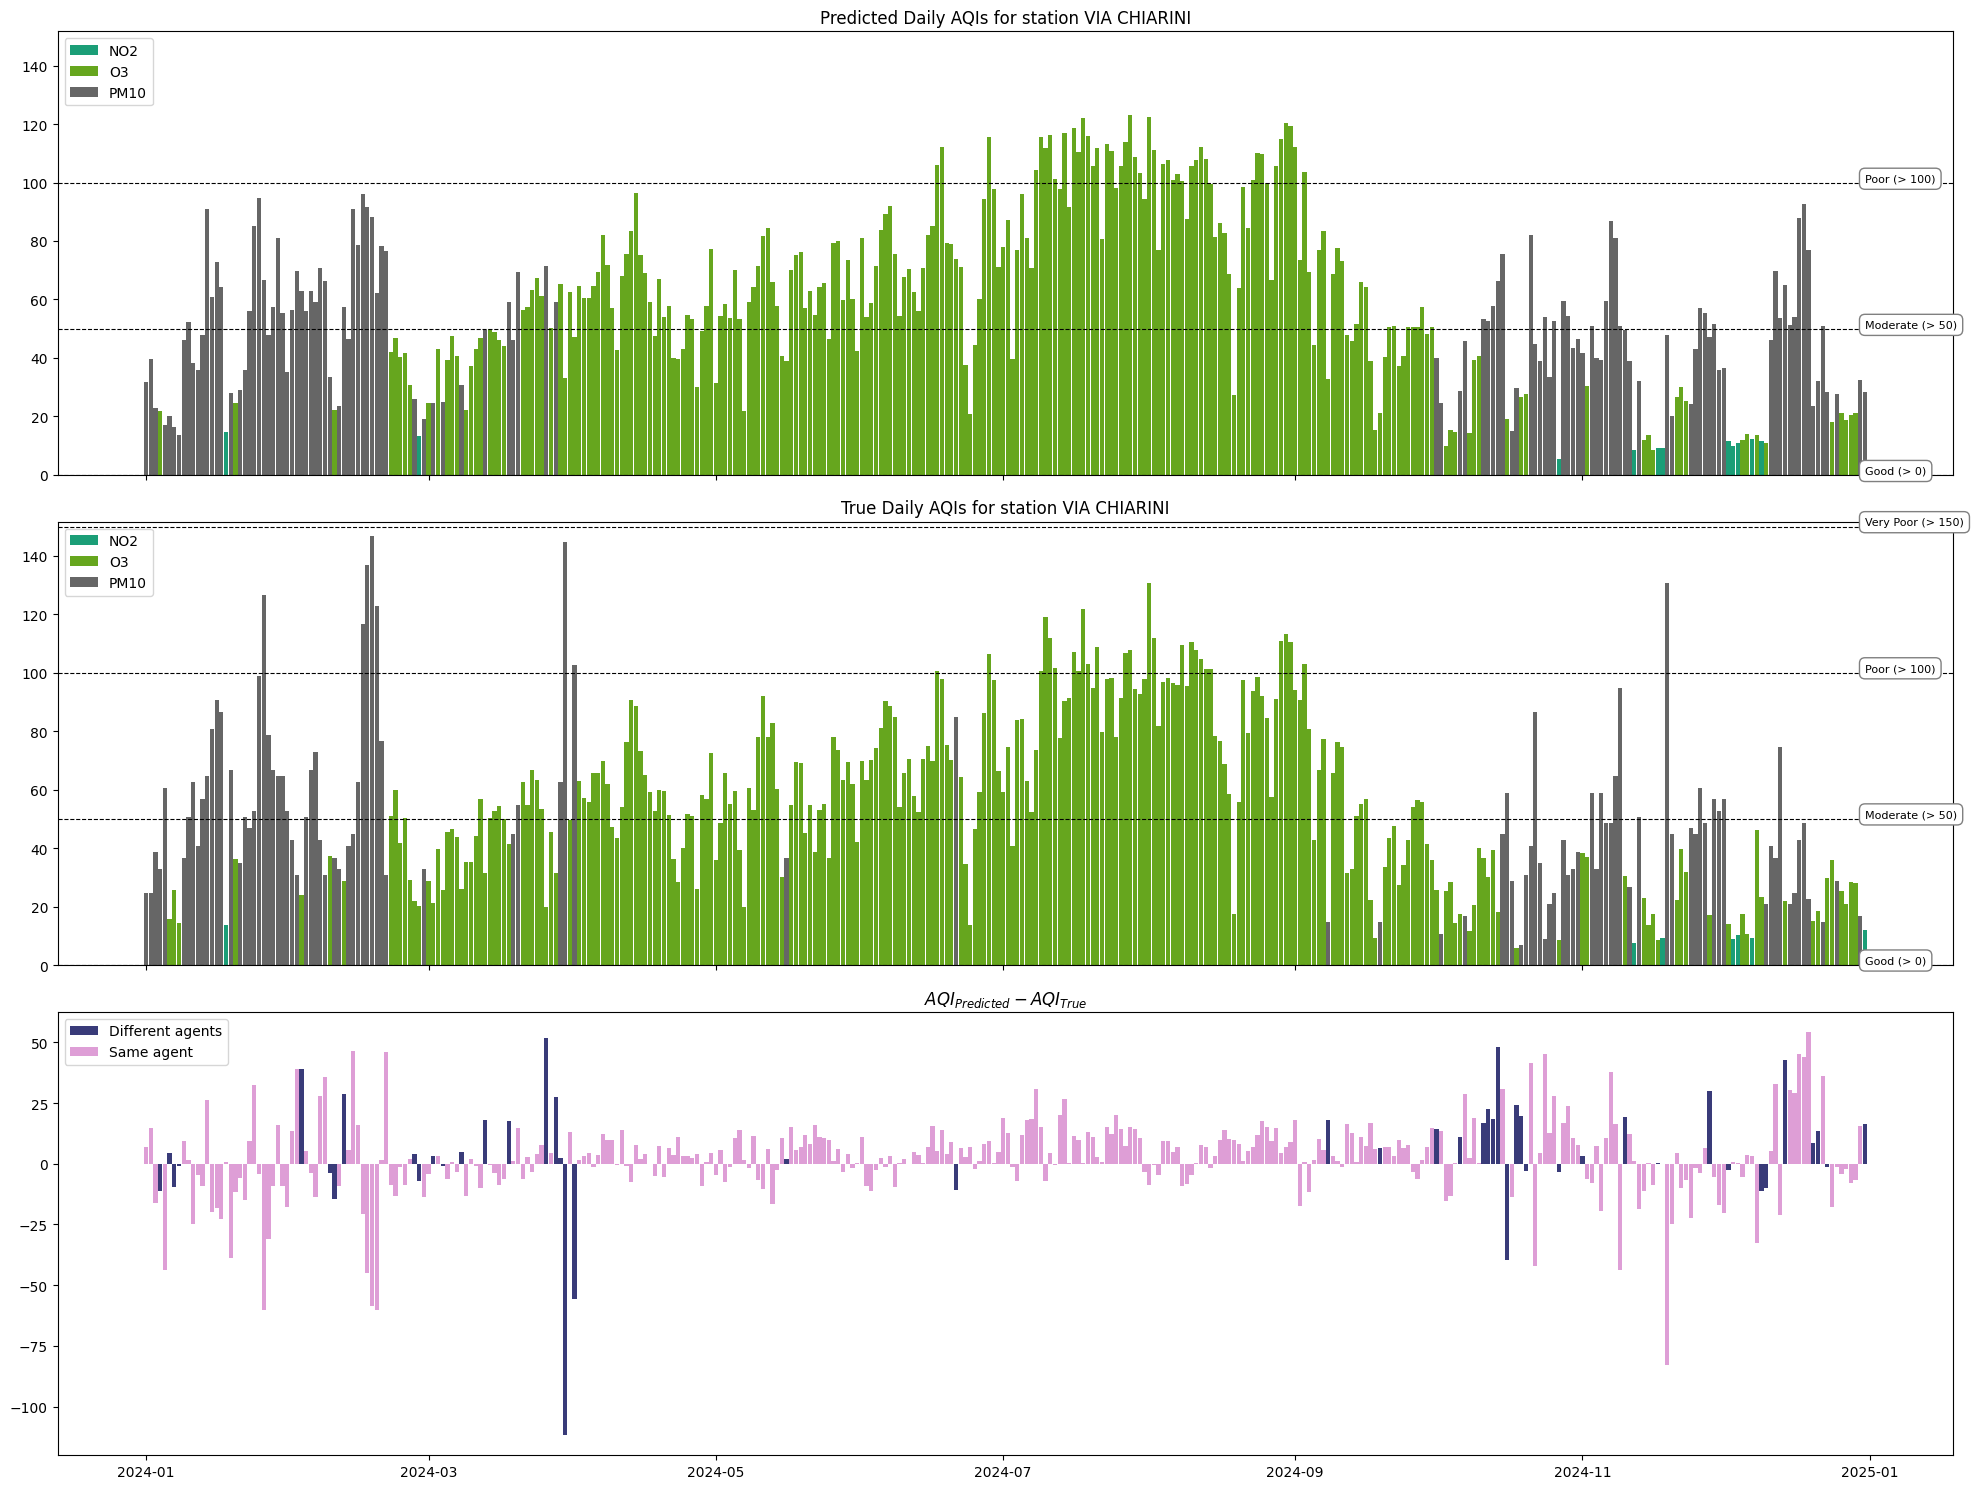

In [42]:
start=datetime(2024,1,1)
end=datetime(2024,12,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        categories=AQI_CATEGORIES,
        figsize=(20, 5), s=start, e=end)

Station GIARDINI MARGHERITA Daily


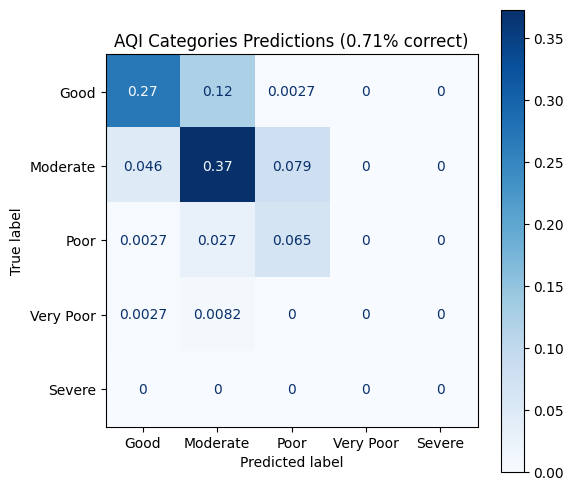

---------------------------------------------
> Absolute Mean AQI Difference: 13.90
> Positive Average AQI Difference: 12.89
> Negative Average AQI Difference: -15.33
> Percentage of Positive Differences: 58.58%
> Percentage of Negative Differences: 41.42%
> Percentage of Agent Values:
   - Same agent: 73.3
   - Different agents: 26.7
Station PORTA SAN FELICE Daily


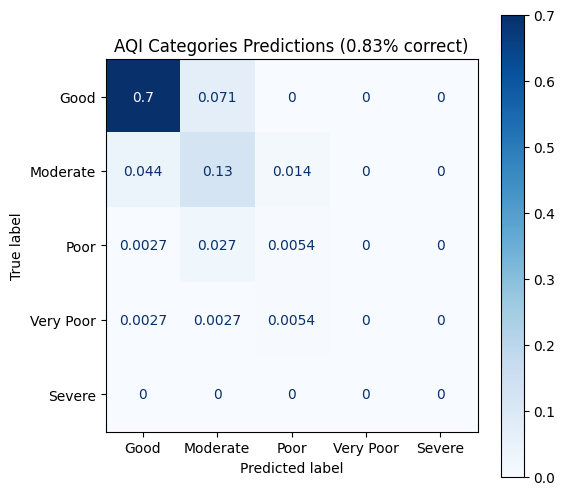

---------------------------------------------
> Absolute Mean AQI Difference: 13.87
> Positive Average AQI Difference: 11.55
> Negative Average AQI Difference: -18.05
> Percentage of Positive Differences: 64.31%
> Percentage of Negative Differences: 35.69%
> Percentage of Agent Values:
   - Same agent: 58.86
   - Different agents: 41.14
Station VIA CHIARINI Daily


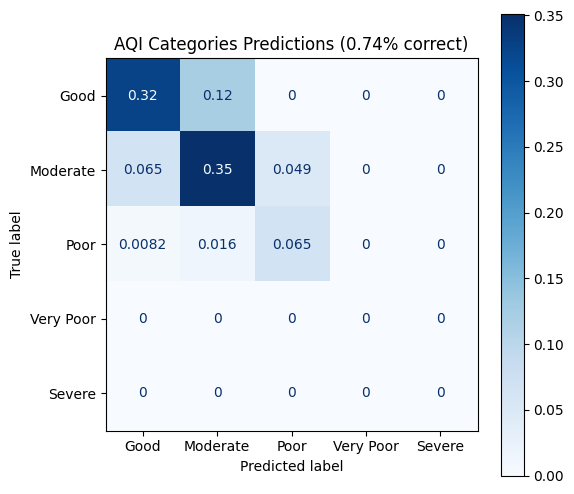

---------------------------------------------
> Absolute Mean AQI Difference: 12.29
> Positive Average AQI Difference: 11.71
> Negative Average AQI Difference: -13.32
> Percentage of Positive Differences: 64.03%
> Percentage of Negative Differences: 35.97%
> Percentage of Agent Values:
   - Same agent: 87.19
   - Different agents: 12.81


In [43]:
for station in pred_AQI_daily:
    print('=============================================')
    print(f'Station {station} Daily')
    print('=============================================')
    print_AQI_category_comparison(
        pred_AQI_daily[station], true_AQI_daily[station], 
        categories=AQI_CATEGORIES
    )
    print('---------------------------------------------')
    print_AQI_difference_metrics(AQI_diff_daily[station])
    print('=============================================')

Thanks to this new model, the daily AQI accuracy gained some points in accuracy in Porta San Felice. The most benefit may come from the PM agents being aggregated and trained together, increasing the amount of training samples.

## **More detailed AQI display**

For the sake of investigation, we may want to create a more dense category dictionary to visualize the AQI prediction accuracy in a more detailed way.

In [50]:
max = 200
step = 25

dense_categories = {
    str(i): i * step for i in range(0, max//step + 1)
}

### **Hourly**

- Nothing relevant from the hourly plot, as we already expected...

### **Daily**

- On another hand, the next plots suggest that the AQI obtained by the model predictions, seems to be really good, nicely following the diagonal of the confusion matrix.

Station GIARDINI MARGHERITA Daily


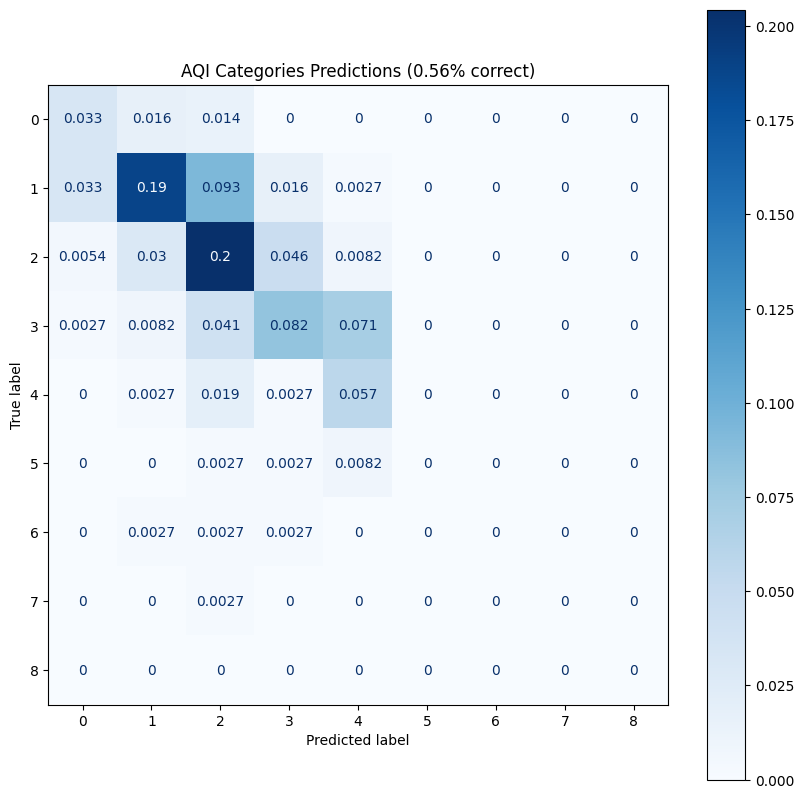

Station PORTA SAN FELICE Daily


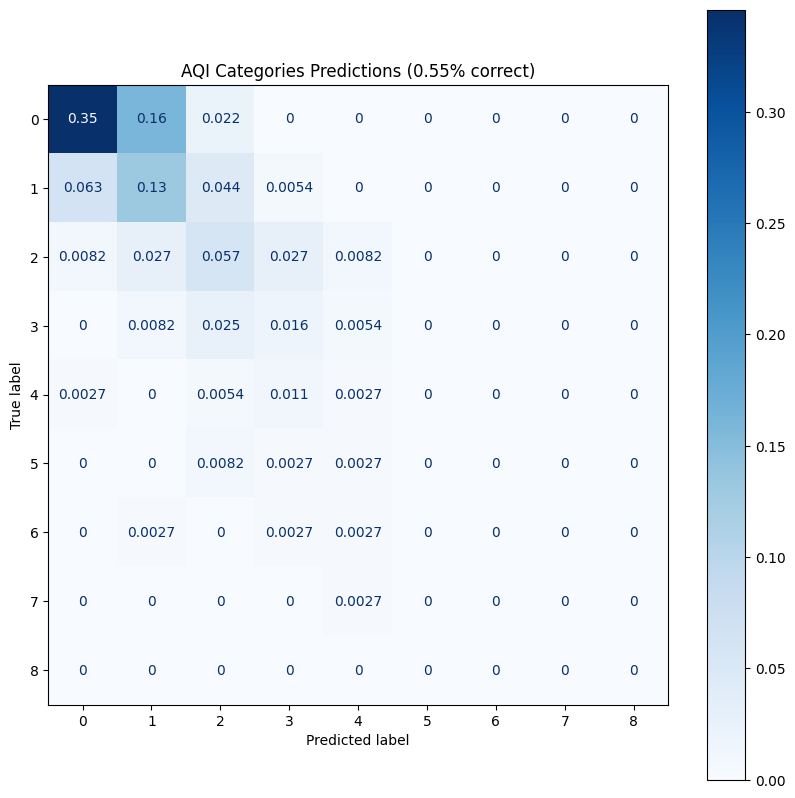

Station VIA CHIARINI Daily


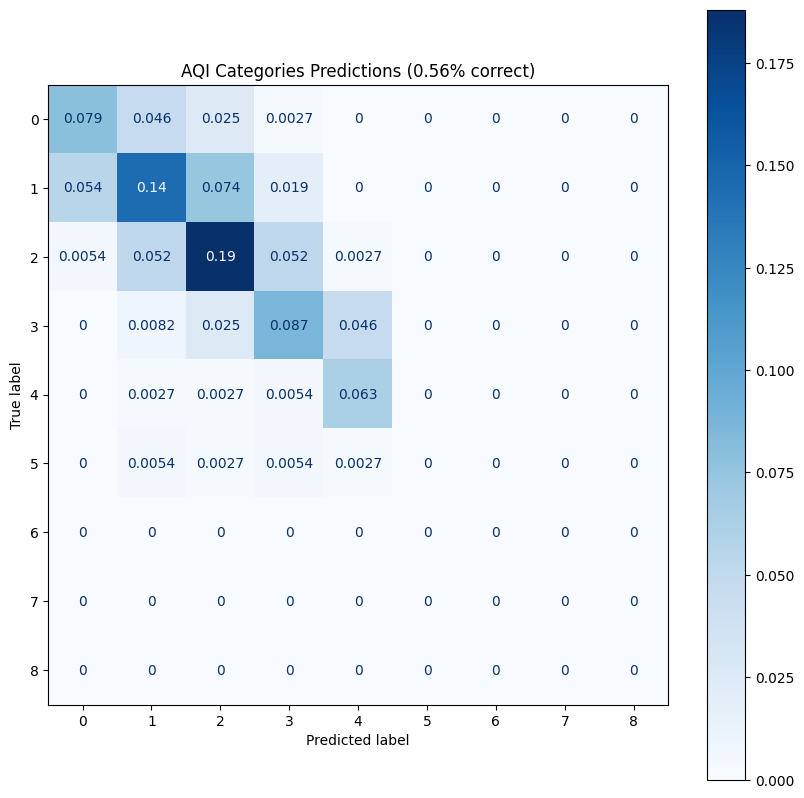

In [51]:
for station in pred_AQI_daily:
    print(f'Station {station} Daily')
    print_AQI_category_comparison(
        pred_AQI_daily[station], true_AQI_daily[station], 
        categories=dense_categories,
        figsize=(10,10)
    )